# AIS GBM
---
## General Remarks <br>

+ The development of this Python script is mainly done with Jupyter notebook <br>
+ The script is run with Python 3.9.15<br>
+ Running time using ``AMD Ryzen 2700X, 16GB RAM``, 20 Minutes 

---

##  Specific to `AIS_BBM`

+ This part of the script focus on BBM side of the GBM
+ Initial data pre-processing, model training and hyperparameter optimisation is performed with this script
+ Please remember to .gitignore the model generated using this script, as the file size can be quite big

---

### Package initialisation

+ Standard packages for ML is loaded 
+ The `joblib` package is used to save the generated model

In [124]:
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
import pickle
import joblib
import time 

### Data preprocessing :

+ Two data sources will be imported 
+ `AIS_weather_h_rename_copy.csv` will be used to complement the information for _true current direction_ and _true wind direction_ 
+ The resulting dataframe will be merged with the dataframe from the `AIS_weather_H_ok2_copy.csv` 
+ The data of the journey between Ronne and Sassnitz will be omitted, the filter is applied at 55.04°



In [125]:
# Parameter to plot in latex fonts
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})

# Load the data to the script

# dfmain = pd.read_csv("AIS_weather_H_ok2_copy.csv",parse_dates=["Time"])
# dfmain = dfmain[dfmain['LAT'] > 55.04 ]
dfmain = pd.read_csv("Hammershus_Clean9Copy.csv",parse_dates=["Time"])


dfpre = pd.read_csv("AIS_Weather_Hammershus_RenameCopy.csv",parse_dates=["Time"])
# dfpre = pd.read_csv("AIS_weather_h_rename_copy.csv",parse_dates=["Time"])
# dfpre = dfpre[dfpre['LAT'] > 55.04 ]

In [126]:
# Check for missing datapoints in dataset
print(dfmain.info())
print(dfpre.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5674 entries, 0 to 5673
Data columns (total 28 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Unnamed: 0                            5674 non-null   int64         
 1   Time                                  5674 non-null   datetime64[ns]
 2   LON                                   5674 non-null   float64       
 3   LAT                                   5674 non-null   float64       
 4   Temperature above oceans              5674 non-null   float64       
 5   Air density above oceans              5537 non-null   float64       
 6   Max wave height                       4833 non-null   float64       
 7   Swell period                          4833 non-null   float64       
 8   Wind wave period                      4833 non-null   float64       
 9   Wave period                           4833 non-null   float64       
 10  

#### Histogram to show anomalies
+ The SOG is not per se anomalies, but the lower speed range may heavily affect the trained model, as the data are clustered at SOG = 0 kt
+ However for current speed, it is indeed anomaly, as this show abnornmal peak 

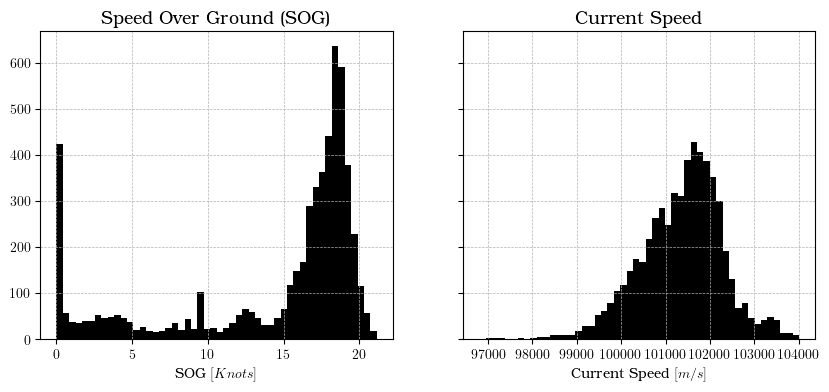

In [127]:
# Anomalies plot

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
dfmain['SOG'].hist(bins=50,color='black')
# Parameter to plot in nice latex fonts
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
plt.grid(linestyle = '--', linewidth = 0.5)
plt.xlabel(r"SOG $[Knots]$")
plt.title(r"Speed Over Ground (SOG)", fontsize=13)
plt.sca(axes[1])
dfmain['Current Speed'].hist(bins=50,color='black')
# Parameter to plot in nice latex fonts
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
plt.grid(linestyle = '--', linewidth = 0.5)
plt.xlabel(r"Current Speed $[m/s]$")
plt.title(r"Current Speed", fontsize=13)
plt.ylabel("")
plt.show()

In [128]:
dfmain.describe()

,Unnamed: 0,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,...,Width,Length,Draught,Wind Speed,Current Speed,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction
count,5674.000000,5674.000000,5674.000000,5674.000000,5537.000000,4833.000000,4833.000000,4833.000000,4833.000000,5518.000000,...,5674.0,5674.0,5674.000000,5674.000000,5674.000000,5674.000000,5674.000000,4833.000000,4833.000000,4833.000000
mean,4565.459993,13.562769,55.174895,283.211265,1.241356,1.539526,4.192236,3.358534,3.750504,284.073456,...,25.0,158.0,5.184219,6.507685,101363.487608,88.645193,83.854069,88.554157,90.904863,89.406629
std,2473.520428,0.863920,0.214607,6.608022,0.033340,1.135701,1.055786,0.992558,0.924154,5.953722,...,0.0,0.0,0.206550,3.096923,942.003507,54.495446,66.452890,53.945460,53.363214,54.890544
min,8.000000,12.196954,54.472520,264.076782,1.158469,0.083379,1.681843,1.547585,1.672565,273.048584,...,25.0,158.0,4.700000,0.248587,96803.312500,0.007213,0.009743,0.031036,0.000278,0.026438
25%,2422.250000,12.838473,55.098445,277.304108,1.213425,0.680961,3.387966,2.567286,3.035258,278.365051,...,25.0,158.0,5.000000,4.107965,100789.609375,39.113640,15.732503,39.393075,44.586418,39.660914
50%,4785.500000,13.688262,55.202769,283.369141,1.238952,1.212586,4.162952,3.275889,3.661390,283.986206,...,25.0,158.0,5.200000,6.164991,101480.000000,88.969360,75.069696,87.287187,90.325749,87.742863
75%,6638.750000,14.465584,55.282776,289.252045,1.267680,2.082325,4.892405,3.915932,4.348891,289.676361,...,25.0,158.0,5.300000,8.513570,101980.656250,138.303142,157.962003,137.137569,137.865856,138.728664
max,8737.000000,14.694543,55.462148,297.933594,1.358713,7.311599,7.531564,7.092444,7.085897,295.253418,...,25.0,158.0,5.700000,18.574455,104016.250000,179.861808,179.984727,179.955297,179.992656,179.999535


### Calculation of ship's true north wind and current direction

+ All features are dropped except for `eastwind`, `northwind`, `eastcurrent`, `northcurrent` , `sog` and `cog`

In [129]:
# Drop all dulplicate feature in dataset "AIS_weather_h_rename_copy.csv"

dfpre = dfpre.drop(dfpre.columns[[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,22,23,26]],axis=1)
dfpre = dfpre.rename({'Eastward wind': 'eastwind', 'Northward wind': 'northwind',
                           'Eastward current': 'eastcurrent', 'Northward current': 'northcurrent',
                           'SOG':'sog','COG':'cog','Heading':'heading'},axis=1) 

### Imputing missing values using `KNNImputer`
+ The dataset is first imputed
+ Then it is transformed

In [130]:
# Imputing the information for the missing east and north current data

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(dfpre)

KNNImputer(n_neighbors=50)

In [131]:
# Transform
x_pre = imputer.transform(dfpre)

### Calculation of true north current and true north wind
+ The current and wind speed can be calculated using pythagoras theorem
+ The current and wind direction is divided into several conditions to ensure that they belong to the suitable quadrants

In [132]:
# Ensure that the imputed value maintains the same column heading 
dfpre = pd.DataFrame(x_pre, columns=dfpre.columns, index=dfpre.index)

In [133]:
# Calculate current and wind speed
dfpre["Current Speed"] = np.sqrt(dfpre["eastcurrent"]**2 + dfpre["northcurrent"]**2)
dfpre["Wind Speed"] = np.sqrt(dfpre["eastwind"]**2 + dfpre["northwind"]**2)

In [134]:
# Calculate the True North wind direction and split them into quadrants

condwind = [(dfpre['eastwind']>0) & (dfpre['northwind']<0),
            (dfpre['eastwind']<0) & (dfpre['northwind']>0),
            (dfpre['eastwind']>0) & (dfpre['northwind']>0)]

choicewind = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"])))]

dfpre["True North Wind Direction"] = np.select(condwind, choicewind, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))))

In [135]:
# Calculate the True North current direction and split them into quadrants
condcurr = [(dfpre['eastcurrent']<0) & (dfpre['northcurrent']>0),
            (dfpre['eastcurrent']>0) & (dfpre['northcurrent']<0),
            (dfpre['eastcurrent']<0) & (dfpre['northcurrent']<0)]

choicecurr = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"])))]

dfpre["True North Current Direction"] = np.select(condcurr, choicecurr, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))))

In [136]:
# Drop further unecessary feature before merging to main dataset
dfpre = dfpre.drop(['eastwind','northwind','eastcurrent','northcurrent','Width','Length'],axis=1)

In [137]:
# Drop the wind speed and current speed from the original dataset as it contains outlier 
dfmain = dfmain.drop(['Wind Speed','Current Speed'],axis=1)

In [138]:
# Combine the the information of true north to main dataset
df = pd.concat([dfmain,dfpre],axis=1)

### SOG threshold
+ The threshold for the ships manouvering speed will be 5 knots ([Abebe20](https://doi.org/10.3390/app10072325),[Yan21](https://doi.org/10.1016/j.tre.2020.101930))
+ Alternatively, outlier rejection using &mu; &plusmn; 3&sigma; ([Gkerekos19](https://doi.org/10.1016/j.oceaneng.2019.106282)), this should increase the threshold to about 8 knots

In [139]:
# SOG threshold according to Abebe20 and Yan21
# df = df[df['SOG'] > 0 ]

df = df[df['SOG'] > 5 ]

# # SOG threshold according to Gkerekos19

# df = df[df['SOG'] > 8 ]

In [140]:
# Length of dataset after speed filter
print(f"Length of speed filter dataset {len(df)}")

Length of speed filter dataset 4762


### Data split into training and test
+ The `random_state` is 42, however to gain different datasets, change the `random_state` to other numbers (arbitrary)

In [141]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.25, random_state=42)

In [142]:
# re-declare that df will be the dataframe used for training 
df = train_set

In [143]:
# Length of test dataset
print(f"Length of train dataset {len(train_set)}")
print(f"Length of test dataset {len(test_set)}")

Length of train dataset 3571
Length of test dataset 1191


### Data Analysis before modelling
+ The steps in this section include: 
    + Feature deletion
    + Feature correlation 
    + Feature deletion 
+ The test dataset will also be preprocessed so for various plots of learning curves and HPO exploration
    

In [144]:
# Remove features that have no impact on model training

df_ship = df.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
                    'Surface pressure','Width','Length'],axis=1)

test_set = test_set.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
                    'Surface pressure','Width','Length'],axis=1)

In [145]:
# Renaming Features 

df_ship2 = df_ship.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

test_set2 = test_set.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

#### In this version of the script
+ No features are dropped with exception to static information
+ ``Surface pressure`` and ``Air density above oceans`` are considered

In [146]:
# df_ship = df.drop(['Unnamed: 0','Time','Width','Length'],axis=1)

# test_set = test_set.drop(['Unnamed: 0','Time','Width','Length'],axis=1)

In [147]:
# # Renaming Features 

# df_ship2 = df_ship.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
#                            'SOG': 'sog', 'Wind Speed': 'windspeed', 
#                            'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
#                            'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
#                             'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
#                             'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
#                             'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
#                             'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
#                             'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir',
#                             'Air density above oceans' : 'rho_air_ao',
#                             'Surface pressure' : 'p_seasurf',
#                            }, axis=1) 

# test_set2 = test_set.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
#                            'SOG': 'sog', 'Wind Speed': 'windspeed', 
#                            'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
#                            'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
#                             'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
#                             'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
#                             'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
#                             'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
#                             'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir',
#                             'Air density above oceans' : 'rho_air_ao',
#                             'Surface pressure' : 'p_seasurf',
#                            }, axis=1) 

In [148]:
# df_ship2 = df_ship2[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir','rho_air_ao','p_seasurf']]

# test_set2 = test_set2[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir','rho_air_ao','p_seasurf']]


In [149]:
# df_ship2.describe()

In [150]:
# df_ship2 = df_ship2[['LON','LAT','oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]

# test_set2 = test_set2[['LON','LAT','oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]

In [151]:
df_ship2 = df_ship2[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]

test_set2 = test_set2[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]


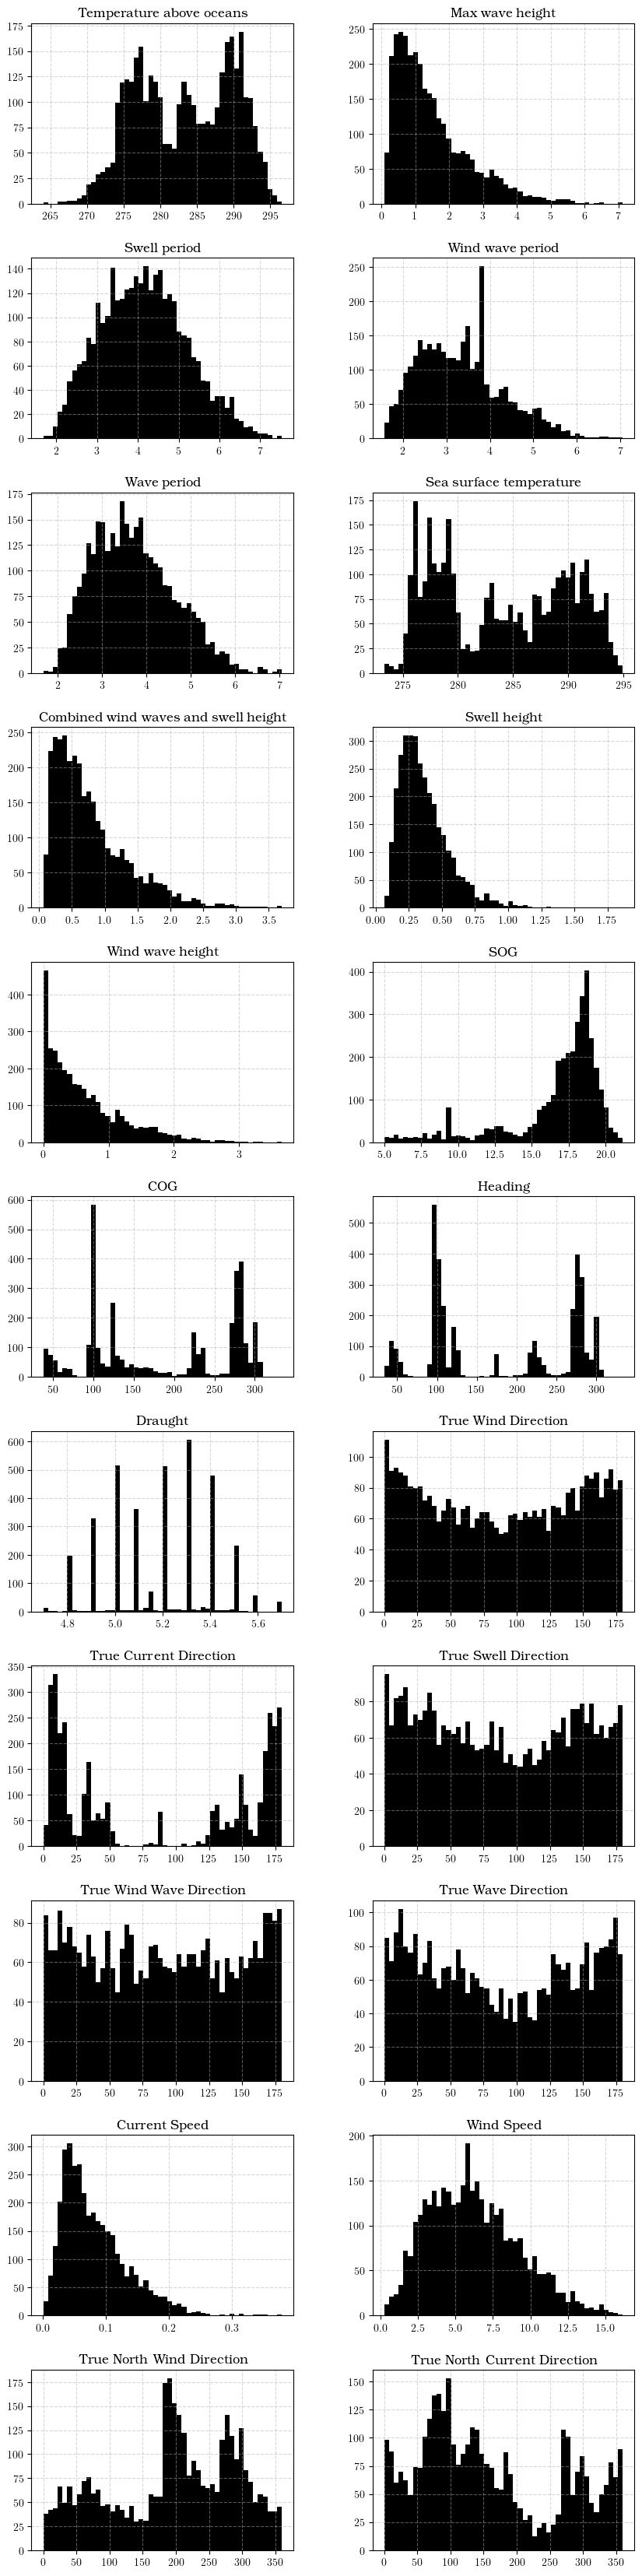

In [152]:
# Histogram plot of pre processed training dataset

# plt.rcParams.update(plt.rcParamsDefault) # Alter default value 
axes = df_ship.hist(bins=50,figsize=(10,50),color='black',grid=True,layout=(13,2))
for ax in axes.flatten():
    ax.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [153]:
# Drop variables such as date from the dataset

dfship_corr = df_ship2.drop(df_ship2.columns[[0,5,15,16,17,18,19,20,21]],axis=1)
print(dfship_corr.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3571 entries, 5608 to 1017
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   waveheight           3235 non-null   float64
 1   swellperiod          3235 non-null   float64
 2   windwaveperiod       3235 non-null   float64
 3   waveperiod           3235 non-null   float64
 4   windwaveswellheight  3235 non-null   float64
 5   swellheight          3235 non-null   float64
 6   windwaveheight       3235 non-null   float64
 7   draught              3571 non-null   float64
 8   sog                  3571 non-null   float64
 9   cog                  3571 non-null   float64
 10  heading              3571 non-null   float64
 11  windspeed            3571 non-null   float64
 12  curspeed             3571 non-null   float64
dtypes: float64(13)
memory usage: 390.6 KB
None


In [154]:
# Function to plot correlation heatmap
def correlation_heatmap(df,fontsize):
    correlations = df.corr()
    # Parameter to plot in nice latex fonts
    plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
    colormap = sns.color_palette("Reds")
    fig, ax = plt.subplots(figsize=(10,10))
    sns.set(font_scale = fontsize)
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',cmap="mako",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
                # ,annot_kws={'fontsize': 12, 'color':'k', 'alpha': 1})
    plt.show();

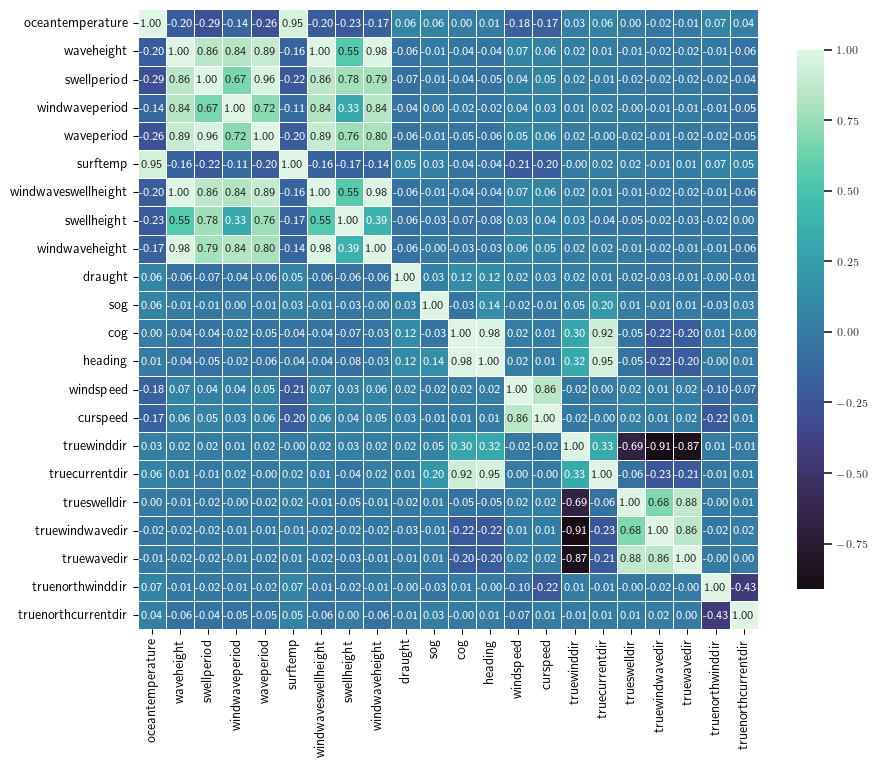

In [155]:
# Heatmap plot of overall dataset

df_ship_ovr = df_ship2
correlation_heatmap(df_ship_ovr,.7)

### Scientific Justification of High Correlation Filter [Abebe20](https://doi.org/10.3390/app10072325): (No feature dropped in this version)

- According to [BitnerGregersen05](https://doi.org/10.1115/OMAE2005-67382), the wind wave swell height is equal to the square root of the square of swell wave and wind wave. Therefore Swell Wave Height and Wind Wave Height is dropped.
- According to [Bretschneider65](https://apps.dtic.mil/sti/citations/ad0612006), the max wave height is 2*H<sub>(1/3)</sub>. This correlation means that maximum wave height, `waveheight` is dropped
- According to [Torsetshaugen04](https://www.semanticscholar.org/paper/Simplified-Double-Peak-Spectral-Model-For-Ocean-Torsethaugen-Haver/0f1b1509791d441861ff6c2940dd13b1f939f149), The type of dominating wave (Wind wave/Swell) can be predicted from an equation which include the significant wave height and a certain threshold, therefore, it is decided that the `windwaveperiod`, ``swellperiod`` and consequently the ``truewindwavedirection`` and ``trueswell direction`` is to be dropped.
- `truenorthdirection` carries less significance, instead the `truedirections` are used which is direction of weather effect w.r.t. the ship bow

In [156]:
df_ship2 = df_ship2.drop(['waveheight','swellheight','windwaveheight',
                        'windwaveperiod','swellperiod',
                        'truewindwavedir','trueswelldir',
                        'truenorthcurrentdir','truenorthwinddir'],axis=1)

test_set2 = test_set2.drop(['waveheight','swellheight','windwaveheight',
                        'windwaveperiod','swellperiod',
                        'truewindwavedir','trueswelldir',
                        'truenorthcurrentdir','truenorthwinddir'],axis=1)

In [157]:
# df_ship2 = df_ship2.drop(['waveheight','swellheight','windwaveheight',
#                         'windwaveperiod','swellperiod',
#                         'truewindwavedir','trueswelldir',
#                         'truenorthcurrentdir','truenorthwinddir','cog','heading'],axis=1)

# test_set2 = test_set2.drop(['waveheight','swellheight','windwaveheight',
#                         'windwaveperiod','swellperiod',
#                         'truewindwavedir','trueswelldir',
#                         'truenorthcurrentdir','truenorthwinddir','cog','heading'],axis=1)

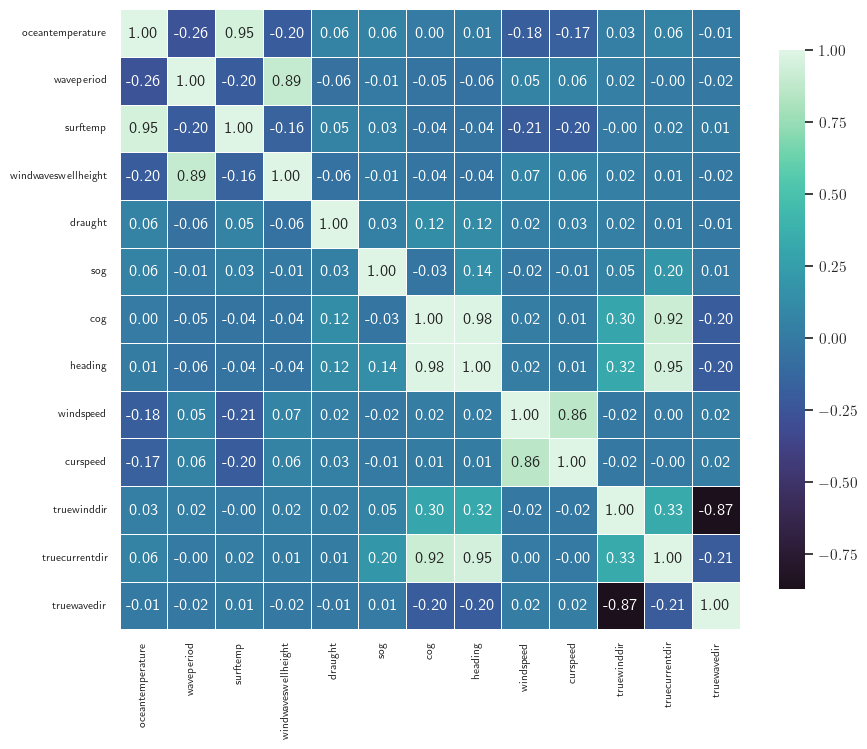

In [158]:
# Heatmap for training feature

correlation_heatmap(df_ship2,1)

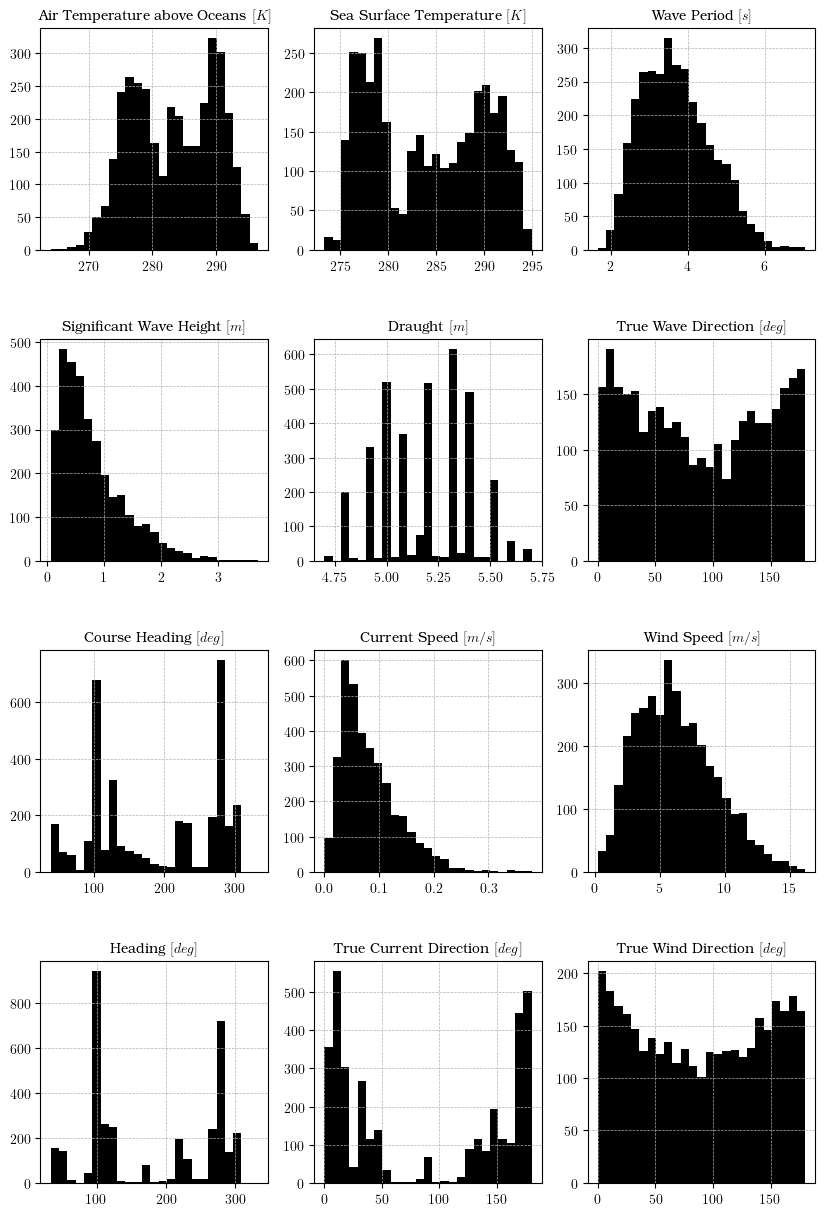

In [159]:
# demonstrate how to toggle the display of different elements:
# Histogram plot of final features and labels for training

fs = 10

plt.rcParams.update(plt.rcParamsDefault)
# Parameter to plot in nice latex fonts
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})

oceantemp = df_ship2['oceantemperature']
waveperiod = df_ship2['waveperiod']
surftemp = df_ship2['surftemp']
sigwave = df_ship2['windwaveswellheight']
draught = df_ship2['draught']
sog = df_ship2['sog']
cog = df_ship2['cog']
hdg = df_ship2['heading']
windspeed = df_ship2['windspeed']
curspeed = df_ship2['curspeed']
truewavedir = df_ship2['truewavedir']
truewind = df_ship2['truewinddir']
truecurrent = df_ship2['truecurrentdir']

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 15))

axes[0, 0].hist(oceantemp,bins=25,color='black')
axes[0, 0].set_title(r'Air Temperature above Oceans $[K]$', fontsize=fs)
axes[0, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[0, 1].hist(surftemp,bins=25,color='black')
axes[0, 1].set_title(r'Sea Surface Temperature $[K]$', fontsize=fs)
axes[0, 1].grid(True,linestyle = '--', linewidth = 0.5)

axes[0, 2].hist(waveperiod,bins=25,color='black')
axes[0, 2].set_title(r'Wave Period $[s]$', fontsize=fs)
axes[0, 2].grid(True,linestyle = '--', linewidth = 0.5)

axes[1, 0].hist(sigwave,bins=25,color='black')
axes[1, 0].set_title(r'Significant Wave Height $[m]$', fontsize=fs)
axes[1, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[1, 1].hist(draught  ,bins=25,color='black')
axes[1, 1].set_title(r'Draught $[m]$', fontsize=fs)
axes[1, 1].grid(True,linestyle = '--', linewidth = 0.5)

axes[1, 2].hist(truewavedir,bins=25,color='black')
axes[1, 2].set_title(r'True Wave Direction $[deg]$', fontsize=fs)
axes[1, 2].grid(True,linestyle = '--', linewidth = 0.5)

axes[2, 0].hist(cog,bins=25,color='black')
axes[2, 0].set_title(r'Course Heading $[deg]$', fontsize=fs)
axes[2, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[2, 1].hist(curspeed,bins=25,color='black')
axes[2, 1].set_title(r'Current Speed $[m/s]$', fontsize=fs)
axes[2, 1].grid(True,linestyle = '--', linewidth = 0.5)

axes[2, 2].hist(windspeed,bins=25,color='black')
axes[2, 2].set_title(r'Wind Speed $[m/s]$', fontsize=fs)
axes[2, 2].grid(True,linestyle = '--', linewidth = 0.5)

axes[3, 0].hist(hdg,bins=25,color='black')
axes[3, 0].set_title(r'Heading $[deg]$', fontsize=fs)
axes[3, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[3, 1].hist(truecurrent,bins=25,color='black')
axes[3, 1].set_title(r'True Current Direction $[deg]$', fontsize=fs)
axes[3, 1].grid(True,linestyle = '--', linewidth = 0.5)

axes[3, 2].hist(truewind,bins=25,color='black')
axes[3, 2].set_title(r'True Wind Direction $[deg]$', fontsize=fs)
axes[3, 2].grid(True,linestyle = '--', linewidth = 0.5)

fig.subplots_adjust(hspace=0.4)
plt.show()

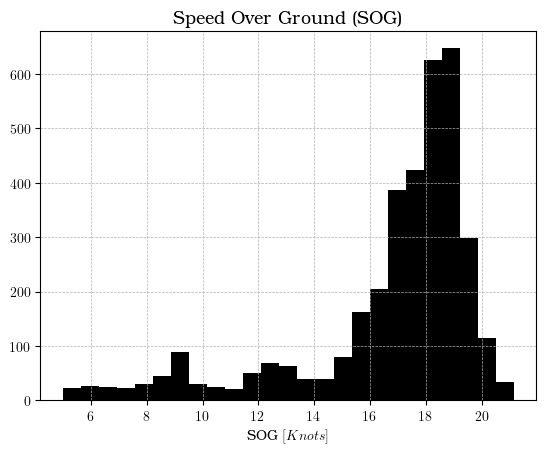

In [160]:
# Profile of SOG 

df_ship2['sog'].hist(bins=25,color='black')
# Parameter to plot in nice latex fonts
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
plt.grid(linestyle = '--', linewidth = 0.5)
plt.xlabel(r"SOG $[Knots]$")
plt.title(r"Speed Over Ground (SOG)", fontsize=13)
plt.show()

### Imputing using KNN so that the all tree-based model by Sklearn may function 
+ The model by sklearn cannot accept `nan` values 
+ The imputing process is the same
    + Impute
    + Transform
    + Column heading matches the heading before imputing

In [161]:
# Impute for training data 

import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(df_ship2)

# Transform

X = imputer.transform(df_ship2)

# Set heading to make sure they have same name 

df_ship2tr = pd.DataFrame(X, columns=df_ship2.columns, index=df_ship2.index)

In [162]:
# Impute for testing data

imputer_tst = KNNImputer(n_neighbors=50)
imputer_tst.fit(test_set2)

# Transform

Xtest = imputer_tst.transform(test_set2)

# Set heading to make sure they have same name 

test_set2tr = pd.DataFrame(Xtest, columns=test_set2.columns, index=test_set2.index)

In [163]:
# Final check to ensure that the data points are all the same

print(df_ship2tr.info())
print(test_set2tr.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3571 entries, 5608 to 1017
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oceantemperature     3571 non-null   float64
 1   waveperiod           3571 non-null   float64
 2   surftemp             3571 non-null   float64
 3   windwaveswellheight  3571 non-null   float64
 4   draught              3571 non-null   float64
 5   sog                  3571 non-null   float64
 6   cog                  3571 non-null   float64
 7   heading              3571 non-null   float64
 8   windspeed            3571 non-null   float64
 9   curspeed             3571 non-null   float64
 10  truewinddir          3571 non-null   float64
 11  truecurrentdir       3571 non-null   float64
 12  truewavedir          3571 non-null   float64
dtypes: float64(13)
memory usage: 390.6 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1191 entries, 979 to 2209
Data columns (to

### Preparation of Training data
+ SOG as target variable
+ Rest as feature

In [164]:
x_train = df_ship2tr.drop(['sog'],axis=1)
y_train = df_ship2tr.sog

x_test = test_set2tr.drop(['sog'],axis=1)
y_test = test_set2tr.sog

In [165]:
print("Amount of the x training dataset are:",len(x_train))

Amount of the x training dataset are: 3571


In [166]:
print("Amount of x test dataset are",len(x_test))

Amount of x test dataset are 1191


In [167]:
# Descriptive statistics of the features
print(x_train.describe())

       oceantemperature   waveperiod     surftemp  windwaveswellheight  \
count       3571.000000  3571.000000  3571.000000          3571.000000   
mean         283.288454     3.718183   284.077564             0.789894   
std            6.543814     0.873475     5.833723             0.539953   
min          264.076782     1.672565   273.325195             0.065236   
25%          277.393616     3.057611   278.550537             0.387260   
50%          283.470947     3.678619   283.950073             0.677807   
75%          289.287720     4.222046   289.509583             1.004460   
max          296.558106     7.047197   294.928223             3.698143   

           draught          cog      heading    windspeed     curspeed  \
count  3571.000000  3571.000000  3571.000000  3571.000000  3571.000000   
mean      5.183872   187.527433   178.811920     6.228932     0.082832   
std       0.210202    87.572332    89.789503     3.003062     0.052863   
min       4.700000    38.058145    33

In [168]:
# Descriptive statistics of target variable
print(y_train.describe())

count    3571.000000
mean       16.730446
std         3.229866
min         5.000213
25%        16.195037
50%        17.844615
75%        18.715287
max        21.160407
Name: sog, dtype: float64


In [169]:
# Cross check with WBM to ensure that the test dataset has the same characteristics
print(x_test.describe())

       oceantemperature   waveperiod     surftemp  windwaveswellheight  \
count       1191.000000  1191.000000  1191.000000          1191.000000   
mean         282.945515     3.745513   283.817198             0.808538   
std            6.693964     0.852211     5.918176             0.551773   
min          265.853058     1.967748   273.048584             0.106645   
25%          277.026001     3.137187   278.277527             0.397821   
50%          282.977295     3.693673   283.452393             0.693676   
75%          289.193970     4.180873   289.408936             1.010680   
max          297.026611     6.929401   294.732666             3.496446   

           draught          cog      heading    windspeed     curspeed  \
count  1191.000000  1191.000000  1191.000000  1191.000000  1191.000000   
mean      5.187500   185.201229   175.649072     6.370372     0.085467   
std       0.209903    86.903295    89.601309     3.046064     0.054757   
min       4.700000    39.652335    36

In [170]:
print(y_test.describe())

count    1191.000000
mean       16.808318
std         3.236891
min         5.051765
25%        16.226408
50%        17.944895
75%        18.796294
max        21.147826
Name: sog, dtype: float64


## Model Training
+ One model is trained with default hyperparameter (HP)
+ Other is optimised (HPO)

Modelling using Random Forest Regressor 

In [171]:
from sklearn.ensemble import RandomForestRegressor
model_rfr_ftr = RandomForestRegressor(random_state=42)
start_rf = time.time()
model_rfr_ftr.fit(x_train,y_train)
end_rf = time.time()
print(f"Training time: {end_rf-start_rf:0.4}s ")

Training time: 5.016s 


HPO RFR

In [172]:
# Optimised for new dataset

from sklearn.ensemble import RandomForestRegressor
model_rfr_ftr_hpov = RandomForestRegressor(n_estimators = 800,
                                            min_samples_split = 5,
                                            min_samples_leaf = 2,
                                            max_features = 10,
                                            max_depth=10,
                                            random_state=42)

# # Prev HPO: (n_estimators = 900,min_samples_split = 2,min_samples_leaf = 2,# max_features = 9,max_depth=200,random_state=42)

start_rfo = time.time()
model_rfr_ftr_hpov.fit(x_train,y_train)
end_rfo = time.time()
print(f"Training time: {end_rfo-start_rfo:0.4}s ")

Training time: 20.35s 


In [173]:
# from sklearn.ensemble import RandomForestRegressor
# model_rfr_ftr_hpov = RandomForestRegressor(n_estimators = 100,
#                                             min_samples_split = 2,
#                                             min_samples_leaf = 1,
#                                             max_features = 10,
#                                             max_depth=120,
#                                             random_state=42)

# # # Prev HPO: (n_estimators = 900,min_samples_split = 2,min_samples_leaf = 2,# max_features = 9,max_depth=200,random_state=42)

# start_rfo = time.time()
# model_rfr_ftr_hpov.fit(x_train,y_train)
# end_rfo = time.time()
# print(f"Training time: {end_rfo-start_rfo:0.4}s ")

Modelling using ETR

In [174]:
from sklearn.ensemble import ExtraTreesRegressor

model_etr = ExtraTreesRegressor(random_state=42)
start_et = time.time()
model_etr.fit(x_train,y_train)
end_et = time.time()
print(f"Training time: {end_et-start_et:0.4}s ")

Training time: 1.171s 


HPO ETR

In [175]:
# Optimised for new dataset

from sklearn.ensemble import ExtraTreesRegressor

model_etr_hpov = ExtraTreesRegressor(random_state=42,
                                n_estimators=300,
                                min_samples_split=8,
                                min_samples_leaf=1,
                                max_features=16,
                                max_depth=30,
                                )

start_eto = time.time()
model_etr_hpov.fit(x_train,y_train)
end_eto = time.time()
print(f"Training time: {end_eto-start_eto:0.4}s")

Training time: 2.144s


In [176]:
# from sklearn.ensemble import ExtraTreesRegressor

# model_etr_hpov = ExtraTreesRegressor(random_state=42,
#                                 n_estimators=800,
#                                 min_samples_split=9,
#                                 min_samples_leaf=1,
#                                 max_features=12,
#                                 max_depth=120,
#                                 )

# start_eto = time.time()
# model_etr_hpov.fit(x_train,y_train)
# end_eto = time.time()
# print(f"Training time: {end_eto-start_eto:0.4}s")

Modelling using Decision Tree Regressor

In [177]:
from sklearn.tree import DecisionTreeRegressor
model_dtr = DecisionTreeRegressor()
start_dtr = time.time()
model_dtr.fit(x_train,y_train)
end_dtr = time.time()
print(f"Training time: {end_dtr-start_dtr:0.4}s")

Training time: 0.05401s


HPO DTR 

In [178]:
# Optimised for new dataset

from sklearn.tree import DecisionTreeRegressor
model_dtr_hpov = DecisionTreeRegressor(min_samples_split=8,
                                  min_samples_leaf=9,
                                  max_features=11,
                                  max_depth=6)
# Old HPO (min_samples_split=2,min_samples_leaf=3,max_features=12,max_depth=10)
start_dtro = time.time()
model_dtr_hpov.fit(x_train,y_train)
end_dtro = time.time()
print(f"Training time: {end_dtro-start_dtro:0.4}s")

Training time: 0.01958s


In [179]:
# from sklearn.tree import DecisionTreeRegressor
# model_dtr_hpov = DecisionTreeRegressor(min_samples_split=7,
#                                   min_samples_leaf=10,
#                                   max_features=12,
#                                   max_depth=8)
# # Old HPO (min_samples_split=2,min_samples_leaf=3,max_features=12,max_depth=10)
# start_dtro = time.time()
# model_dtr_hpov.fit(x_train,y_train)
# end_dtro = time.time()
# print(f"Training time: {end_dtro-start_dtro:0.4}s")

Modelling using Multiple Linear Regression

In [180]:
from sklearn import linear_model
model_mlr = linear_model.LinearRegression()
start_mlr = time.time()
model_mlr.fit(x_train,y_train)
end_mlr = time.time()
print(f"Training time: {end_mlr-start_mlr:0.4}s")

Training time: 0.003001s


Save model to local directory
+ Uncomment this section if you are already satisfied with your model performance after performing HPO
+ Do not forget to add `.gitignore` for the `.sav` extensions !
+ Change the name to your liking at filename 

In [181]:
# # Saving the model to local directory

# filename = 'savemodel_rfr_ftr.sav'
# joblib.dump(model_rfr_ftr,filename)

# filename = 'savemodel_rfr_ftr_hpov.sav'
# joblib.dump(model_rfr_ftr_hpov,filename)

# filename = 'savemodel_etr.sav'
# joblib.dump(model_etr,filename)

# filename = 'savemodel_etr_hpov.sav'
# joblib.dump(model_etr_hpov,filename)

# filename = 'savemodel_dtr_ftr.sav'
# joblib.dump(model_dtr,filename)

# filename = 'savemodel_dtr_hpov.sav'
# joblib.dump(model_dtr_hpov,filename)

# filename = 'savemodel_mlr_ftr.sav'
# joblib.dump(model_mlr,filename)

# Save model that considers all features

# filename = 'savemodel_rfr_ftr_all.sav'
# joblib.dump(model_rfr_ftr,filename)

# filename = 'savemodel_rfr_ftr_hpov_all.sav'
# joblib.dump(model_rfr_ftr_hpov,filename)

# filename = 'savemodel_etr_all.sav'
# joblib.dump(model_etr,filename)

# filename = 'savemodel_etr_hpov_all.sav'
# joblib.dump(model_etr_hpov,filename)

# filename = 'savemodel_dtr_ftr_all.sav'
# joblib.dump(model_dtr,filename)

# filename = 'savemodel_dtr_hpov_all.sav'
# joblib.dump(model_dtr_hpov,filename)

# filename = 'savemodel_mlr_ftr_all.sav'
# joblib.dump(model_mlr,filename)

# Save Model with new datasets

In [182]:
filename = 'savemodel_rfr_ftr_newds.sav'
joblib.dump(model_rfr_ftr,filename)

filename = 'savemodel_rfr_ftr_hpov_newds.sav'
joblib.dump(model_rfr_ftr_hpov,filename)

filename = 'savemodel_etr_newds.sav'
joblib.dump(model_etr,filename)

filename = 'savemodel_etr_hpov_newds.sav'
joblib.dump(model_etr_hpov,filename)

filename = 'savemodel_dtr_ftr_newds.sav'
joblib.dump(model_dtr,filename)

filename = 'savemodel_dtr_hpov_newds.sav'
joblib.dump(model_dtr_hpov,filename)

filename = 'savemodel_mlr_ftr_newds.sav'
joblib.dump(model_mlr,filename)

['savemodel_mlr_ftr_newds.sav']

Ignore this section with permutation importance, still need improvements !

In [183]:
# from sklearn.inspection import permutation_importance

# permu_rest = permutation_importance(model_rfr_ftr_hpov,x_train,y_train,n_repeats=5,random_state=42)

# permu_rest.importances_mean
# permu_rest.importances_std

In [184]:
# def permu_importance(model_type,x_data,y_data):
#     from sklearn.inspection import permutation_importance
#     permu_rest = permutation_importance(model_type,x_data,y_data,n_repeats=10,random_state=42)
#     permu_mean = permu_rest.importances_mean
#     df_mod_imp = pd.DataFrame(permu_mean,index= x_train.columns,columns=["Importance"])
#     print(df_mod_imp.sort_values(by=['Importance'],ascending=False))


In [185]:
# permu_importance(model_rfr_ftr_hpov,x_train,y_train)

### Exploration of effect of different HP
+ Performed to save time on searching in unpromising areas
    + `max_features` : number of features considered when performing splits
    + ``min_samples_leaf`` : number of samples at leaf node
    + ``n_estimators`` : number of trees in a forest, irrelevant for DT
    + ``max_depth`` : controls the depth of the tree 
    + ``min_sample_split`` : minimum number of samples to split a node (minimal 2)
    ---

``max_features`` HPO

In [186]:
# explore random forest number of features effect on performance, v2 optimised for comparison plot between decision tree and random forest
def feature_curve(x,y,regressor,regname):
	from numpy import mean
	from numpy import std
	from sklearn.model_selection import cross_val_score
	from sklearn.model_selection import KFold

	plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})

	# get a list of models to evaluate
	def get_modelsftr():
		models_ftr = dict()
		# explore number of features from 1 to 13
		for n in range(1,23):
			if regressor == 'dt':
				models_ftr[str(n)] = DecisionTreeRegressor(max_features=n)
			elif regressor == 'rf':
				models_ftr[str(n)] = RandomForestRegressor(max_features=n)
			elif regressor == 'et':
				models_ftr[str(n)] = ExtraTreesRegressor(max_features=n)	
		return models_ftr

	# evaluate a given model using cross-validation
	def evaluate_model(model, x, y):
		# define the evaluation procedure
		cv = KFold(n_splits=10, shuffle=True, random_state=1)
		# evaluate the model and collect the results
		scores = cross_val_score(model, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
		# negative scores due to scoring mechanism of sklearn
		return -scores

	# get the models to evaluate
	models_ftr = get_modelsftr()
	# evaluate the models and store results
	results_ftr, names_ftr = list(), list()
	for name, model in models_ftr.items():
		# evaluate the model
		scores_ftr = evaluate_model(model, x, y)
		# store the results
		results_ftr.append(scores_ftr)
		names_ftr.append(name)
		# summarize the performance along the way
		print('>%s %.3f (%.3f)' % (name, mean(scores_ftr), std(scores_ftr)))
	
	# Calculate mean for the x value of the plot

	mean_ftr = np.mean(results_ftr,axis=1)
	min_error_ftr = np.min(mean_ftr)

	print(f"The minimum MAE obtained is {min_error_ftr:.3f}")
	
	plt.plot(names_ftr,mean_ftr,"b.-")
	plt.grid(linestyle = '--', linewidth = 0.5)
	# plt.xlim(0,12-1)
	# plt.ylim(0,2.5)
	plt.xlabel(r"Number of features",fontsize=13)
	plt.ylabel(r"MAE [knots]",fontsize=13)
	plt.title(rf"{regname}", fontsize=14)
	plt.boxplot(results_ftr, labels=names_ftr,positions=range(len(names_ftr)), showmeans=True)

>1 1.873 (0.278)
>2 1.499 (0.178)
>3 1.307 (0.213)
>4 1.121 (0.143)
>5 1.245 (0.154)
>6 1.117 (0.135)
>7 1.091 (0.130)
>8 1.035 (0.086)
>9 1.090 (0.091)
>10 1.013 (0.101)
>11 0.986 (0.080)
>12 0.980 (0.091)
>13 0.991 (0.102)
>14 1.007 (0.105)
>15 0.978 (0.104)
>16 0.989 (0.100)
>17 1.012 (0.098)
>18 0.993 (0.118)
>19 0.980 (0.119)
>20 0.998 (0.116)
>21 1.000 (0.093)
>22 0.990 (0.082)
The minimum MAE obtained is 0.978
>1 1.314 (0.088)
>2 1.016 (0.077)
>3 0.914 (0.089)
>4 0.834 (0.093)
>5 0.802 (0.105)
>6 0.789 (0.100)
>7 0.784 (0.101)
>8 0.776 (0.104)
>9 0.777 (0.102)
>10 0.771 (0.093)
>11 0.774 (0.101)
>12 0.779 (0.103)
>13 0.774 (0.096)
>14 0.775 (0.095)
>15 0.776 (0.098)
>16 0.779 (0.101)
>17 0.779 (0.103)
>18 0.779 (0.098)
>19 0.770 (0.092)
>20 0.779 (0.096)
>21 0.779 (0.101)
>22 0.781 (0.104)
The minimum MAE obtained is 0.770
>1 1.458 (0.098)
>2 1.117 (0.076)
>3 0.967 (0.076)
>4 0.882 (0.066)
>5 0.822 (0.078)
>6 0.792 (0.088)
>7 0.772 (0.094)
>8 0.765 (0.096)
>9 0.752 (0.098)
>10 0

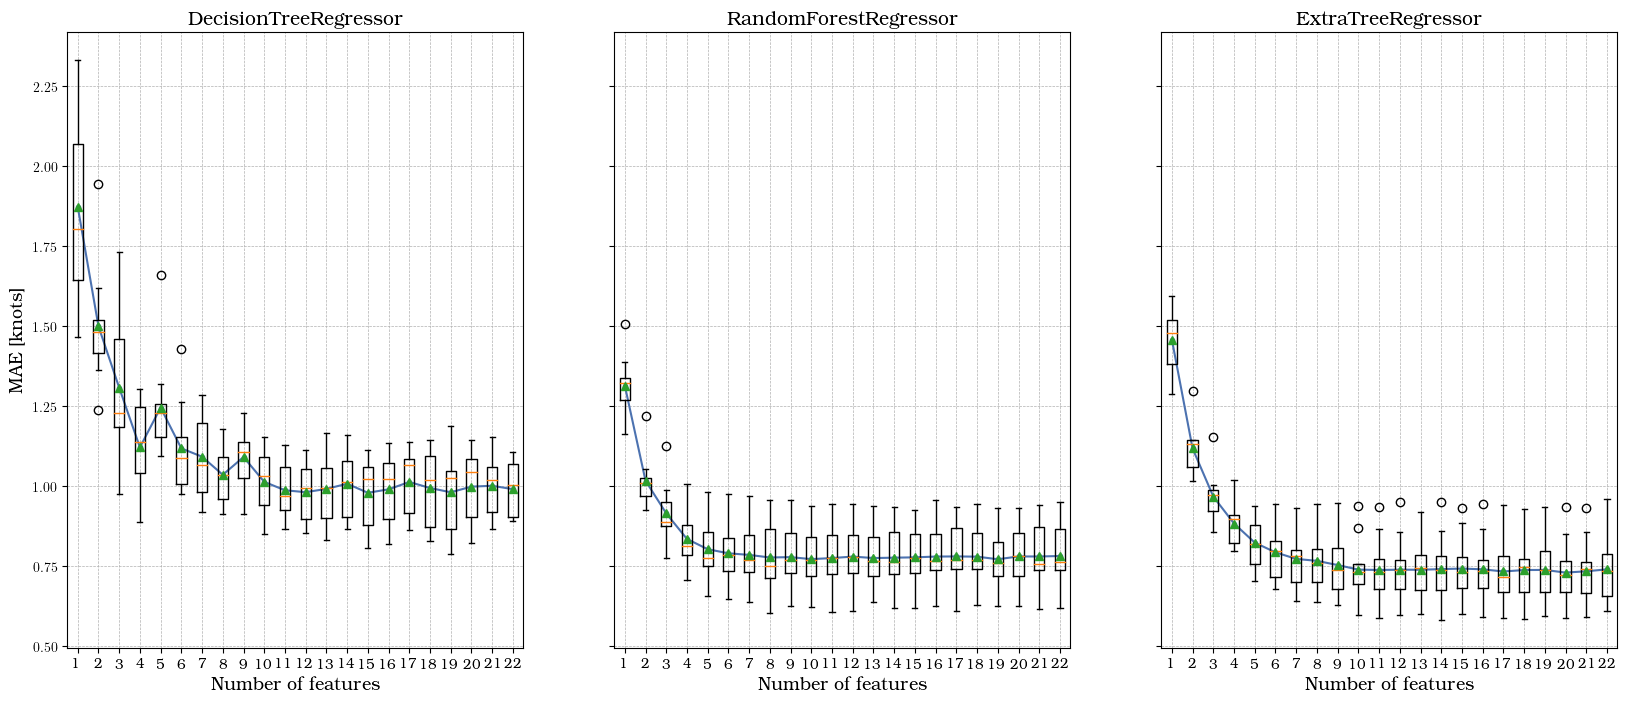

In [187]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 8), sharey=True)
plt.sca(axes[0])
feature_curve(x_test,y_test,regressor='dt',regname='DecisionTreeRegressor')
plt.sca(axes[1])
feature_curve(x_test,y_test,regressor='rf',regname='RandomForestRegressor')
plt.ylabel("")
plt.sca(axes[2])
feature_curve(x_test,y_test,regressor='et',regname='ExtraTreeRegressor')
plt.ylabel("")
plt.show()

``min_samples_leaf`` HPO

In [188]:
# Investigate the effect of samples at leaf node
def leaf_curve(x,y,regressor,regname):
	from numpy import mean
	from numpy import std
	from sklearn.model_selection import cross_val_score

	plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})

	# get a list of models to evaluate
	def get_models_leaf():
		models_leaf = dict()
		# define number of trees to consider
		n_samples_leaf = [1,2,3,4,5,6,7,8,9,10,50]
		for n in n_samples_leaf:
			if regressor == 'dt':
				models_leaf[str(n)] = DecisionTreeRegressor(min_samples_leaf = n)
			if regressor == 'rf':
				models_leaf[str(n)] = RandomForestRegressor(min_samples_leaf = n)
			if regressor == 'et':
				models_leaf[str(n)] = ExtraTreesRegressor(min_samples_leaf = n)
		return models_leaf

	# evaluate a given model using cross-validation
	def evaluate_model(model, x, y):
		scores = cross_val_score(model, x, y, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1)
		return -scores

	# # define dataset
	# get the models to evaluate
	models_leaf = get_models_leaf()

	# evaluate the models and store results
	results_leaf, names_leaf = list(), list()
	for name, model in models_leaf.items():
		# evaluate the model
		scores_leaf = evaluate_model(model, x, y)
		# store the results
		results_leaf.append(scores_leaf)
		names_leaf.append(name)
		# summarize the performance along the way
		print('>%s %.3f (%.3f)' % (name, mean(scores_leaf), std(scores_leaf)))


	mean_leaf = np.mean(results_leaf,axis=1)
	min_error_leaf = np.min(mean_leaf)
	print(min_error_leaf)
	bst_n_estimators_leaf = np.argmin(mean_leaf)
	print(f"The minimum MAE obtained is {min_error_leaf:.3f}")
	plt.plot(names_leaf,mean_leaf,"b.-")
	plt.grid(linestyle = '--', linewidth = 0.5)
	# plt.xlim(0,12-1)
	plt.ylim(0,2.5)
	plt.xlabel(r"Number of Samples in Leaf",fontsize=13)
	plt.ylabel(r"MAE [knots]",fontsize=13)
	plt.title(rf"{regname}", fontsize=14)
	plt.boxplot(results_leaf, labels=names_leaf,positions=range(len(names_leaf)), showmeans=True)

>1 1.008 (0.070)
>2 0.967 (0.053)
>3 0.984 (0.071)
>4 0.973 (0.072)
>5 0.926 (0.053)
>6 0.921 (0.056)
>7 0.908 (0.071)
>8 0.903 (0.075)
>9 0.882 (0.049)
>10 0.878 (0.080)
>50 1.086 (0.105)
0.8775549443332957
The minimum MAE obtained is 0.878
>1 0.772 (0.071)
>2 0.766 (0.067)
>3 0.763 (0.074)
>4 0.761 (0.070)
>5 0.769 (0.076)
>6 0.775 (0.074)
>7 0.783 (0.071)
>8 0.784 (0.072)
>9 0.785 (0.073)
>10 0.791 (0.075)
>50 1.158 (0.171)
0.7610888363996888
The minimum MAE obtained is 0.761
>1 0.734 (0.087)
>2 0.739 (0.090)
>3 0.755 (0.094)
>4 0.768 (0.098)
>5 0.777 (0.092)
>6 0.791 (0.103)
>7 0.803 (0.098)
>8 0.821 (0.103)
>9 0.827 (0.108)
>10 0.842 (0.101)
>50 1.278 (0.150)
0.7338080314154812
The minimum MAE obtained is 0.734


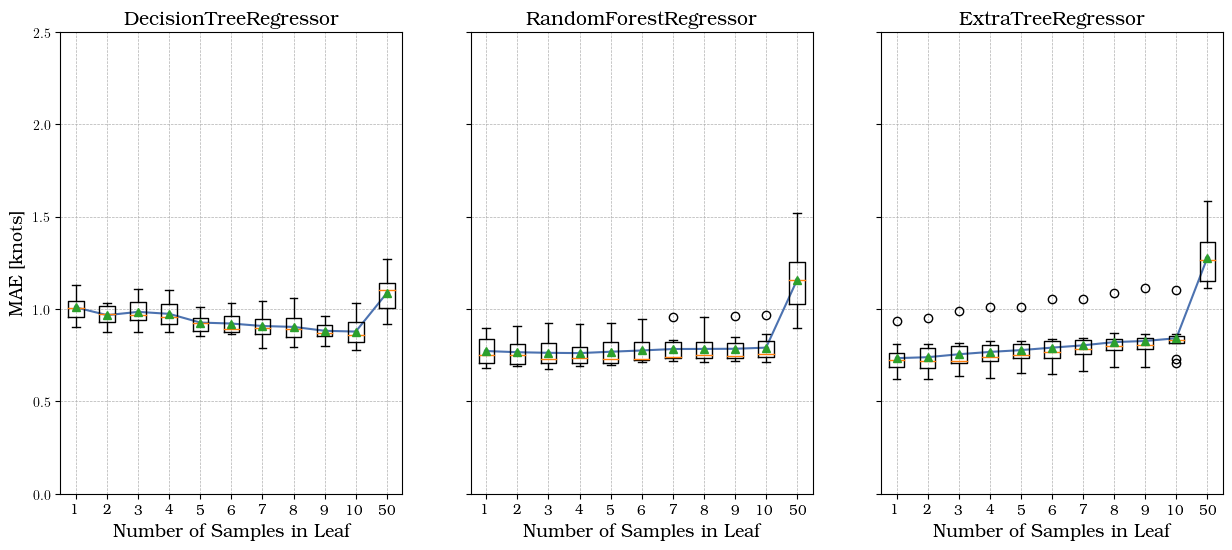

In [189]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 6), sharey=True)
plt.sca(axes[0])
leaf_curve(x_test,y_test,regressor='dt',regname='DecisionTreeRegressor')
plt.sca(axes[1])
leaf_curve(x_test,y_test,regressor='rf',regname='RandomForestRegressor')
plt.ylabel("")
plt.sca(axes[2])
leaf_curve(x_test,y_test,regressor='et',regname='ExtraTreeRegressor')
plt.ylabel("")
plt.show()

``n_estimators`` HPO, irrelevant for DT

In [190]:
# explore random forest and extra tree number of trees effect on performance
def trees_curve(x,y,regressor,regname):
	from numpy import mean
	from numpy import std
	from sklearn.model_selection import cross_val_score

	plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})

	# get a list of models to evaluate
	def get_models_tree():
		models_tree = dict()
		# define number of trees to consider
		n_trees = [1,10,100,200,300,400,500,600,700,800,900,1000]
		for n in n_trees:
			if regressor == 'rf':
				models_tree[str(n)] = RandomForestRegressor(n_estimators = n)
			elif regressor == 'et':
				models_tree[str(n)] = ExtraTreesRegressor(n_estimators = n)	
		return models_tree

	# evaluate a given model using cross-validation
	def evaluate_model(model_tree, x, y):
		scores = cross_val_score(model, x, y, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1)
		return -scores

	# # define dataset
	# get the models to evaluate
	models_tree = get_models_tree()

	# evaluate the models and store results
	results_tree, names_tree = list(), list()
	for name, model in models_tree.items():
		# evaluate the model
		scores_tree = evaluate_model(model, x, y)
		# store the results
		results_tree.append(scores_tree)
		names_tree.append(name)
		# summarize the performance along the way
		print('>%s %.3f (%.3f)' % (name, mean(scores_tree), std(scores_tree)))


	mean_tree = np.mean(results_tree,axis=1)
	min_error_tree = np.min(mean_tree)
	print(min_error_tree)
	print(f"The minimum MAE obtained is {min_error_tree:.3f}")
	plt.plot(names_tree,mean_tree,"b.-")
	plt.grid(linestyle = '--', linewidth = 0.5)
	# plt.xlim(0,12-1)
	plt.ylim(0,2.5)
	plt.xlabel(r"Number of Trees", fontsize=13)
	plt.ylabel(r"MAE [knots]", fontsize=13)
	plt.title(rf"{regname}", fontsize=14)
	plt.boxplot(results_tree, labels=names_tree, showmeans=True,positions=range(len(names_tree)))


>1 1.101 (0.085)
>10 0.818 (0.065)
>100 0.774 (0.077)
>200 0.766 (0.076)
>300 0.766 (0.076)
>400 0.765 (0.077)
>500 0.763 (0.075)
>600 0.765 (0.075)
>700 0.764 (0.076)
>800 0.766 (0.075)
>900 0.765 (0.075)
>1000 0.764 (0.076)
0.7628058697171461
The minimum MAE obtained is 0.763
>1 1.030 (0.148)
>10 0.785 (0.091)
>100 0.735 (0.081)
>200 0.729 (0.090)
>300 0.728 (0.088)
>400 0.729 (0.085)
>500 0.729 (0.087)
>600 0.726 (0.086)
>700 0.728 (0.087)
>800 0.728 (0.086)
>900 0.727 (0.085)
>1000 0.731 (0.086)
0.7262273590046335
The minimum MAE obtained is 0.726


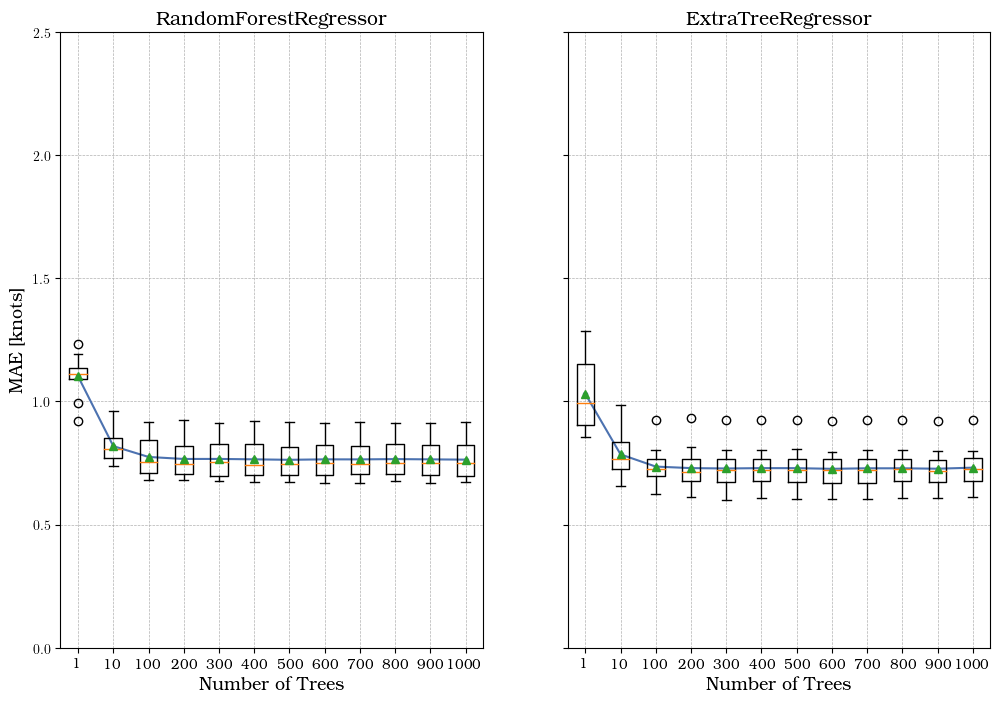

In [191]:
fig, axes = plt.subplots(ncols=2, figsize=(12,8), sharey=True)
plt.sca(axes[0])
trees_curve(x_test,y_test,regressor='rf',regname='RandomForestRegressor')
plt.sca(axes[1])
trees_curve(x_test,y_test,regressor='et',regname='ExtraTreeRegressor')
plt.ylabel("")
plt.show()

``max_depth`` HPO

In [192]:
# explore tree based , tree depth. effect on performance
def depth_curve(x,y,regressor,regname):
	from numpy import mean
	from numpy import std
	from sklearn.model_selection import cross_val_score
	from sklearn.model_selection import KFold

	# Parameter to plot in nice latex font

	plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})

	# get a list of models to evaluate
	def get_models_dp():
		models_dp = dict()
		# consider tree depths from 1 to 7 and None=full
		depths = [1,2,3,4,5,6,7,8,9,10,100] + [None]
		for n in depths:
			if regressor == 'dt':
				models_dp[str(n)] = DecisionTreeRegressor(max_depth=n)
			elif regressor == 'rf':
				models_dp[str(n)] = RandomForestRegressor(max_depth=n)
			elif regressor == 'et':
				models_dp[str(n)] = ExtraTreesRegressor(max_depth=n)	
		return models_dp

	# evaluate a given model using cross-validation
	def evaluate_model(model, x, y):
		# define the evaluation procedure
		cv = KFold(n_splits=10, shuffle=True, random_state=1)
		# evaluate the model and collect the results
		scores = cross_val_score(model, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
		# negative scores due to scoring mechanism of sklearn
		return -scores

	# get the models to evaluate
	models_dp = get_models_dp()
	# evaluate the models and store results
	results_dp, names_dp = list(), list()
	for name, model in models_dp.items():
		# evaluate the model
		scores_dp = evaluate_model(model, x, y)
		# store the results
		results_dp.append(scores_dp)
		names_dp.append(name)
		# summarize the performance along the way
		print('>%s %.3f (%.3f)' % (name, mean(scores_dp), std(scores_dp)))


	mean_dp = np.mean(results_dp,axis=1)
	min_error_dp = np.min(mean_dp)
	print(min_error_dp)
	bst_n_estimators_dp= np.argmin(mean_dp)
	print(f"The minimum MAE obtained is {min_error_dp:.3f}")
	plt.plot(names_dp,mean_dp,"b.-")
	plt.grid(linestyle = '--', linewidth = 0.5)
	# plt.ylim(0,2.5)
	plt.xlabel(r"Tree Depth",fontsize=13)
	plt.ylabel(r"MAE [knots]",fontsize=13)
	plt.title(rf"{regname}", fontsize=14)
	plt.boxplot(results_dp, labels=names_dp,positions=range(len(names_dp)), showmeans=True)

>1 2.162 (0.209)
>2 1.447 (0.128)
>3 1.211 (0.042)
>4 0.913 (0.055)
>5 0.865 (0.107)
>6 0.833 (0.112)
>7 0.850 (0.118)
>8 0.871 (0.129)
>9 0.890 (0.113)
>10 0.925 (0.123)
>100 0.993 (0.099)
>None 1.009 (0.098)
0.8326749765947257
The minimum MAE obtained is 0.833
>1 2.152 (0.219)
>2 1.387 (0.123)
>3 1.140 (0.090)
>4 0.866 (0.083)
>5 0.819 (0.095)
>6 0.793 (0.104)
>7 0.778 (0.099)
>8 0.780 (0.092)
>9 0.780 (0.099)
>10 0.776 (0.093)
>100 0.775 (0.093)
>None 0.778 (0.101)
0.775170022541334
The minimum MAE obtained is 0.775
>1 2.245 (0.170)
>2 1.860 (0.098)
>3 1.512 (0.108)
>4 1.184 (0.115)
>5 0.964 (0.081)
>6 0.853 (0.089)
>7 0.791 (0.091)
>8 0.755 (0.100)
>9 0.738 (0.099)
>10 0.731 (0.102)
>100 0.740 (0.105)
>None 0.736 (0.100)
0.7306384357101722
The minimum MAE obtained is 0.731


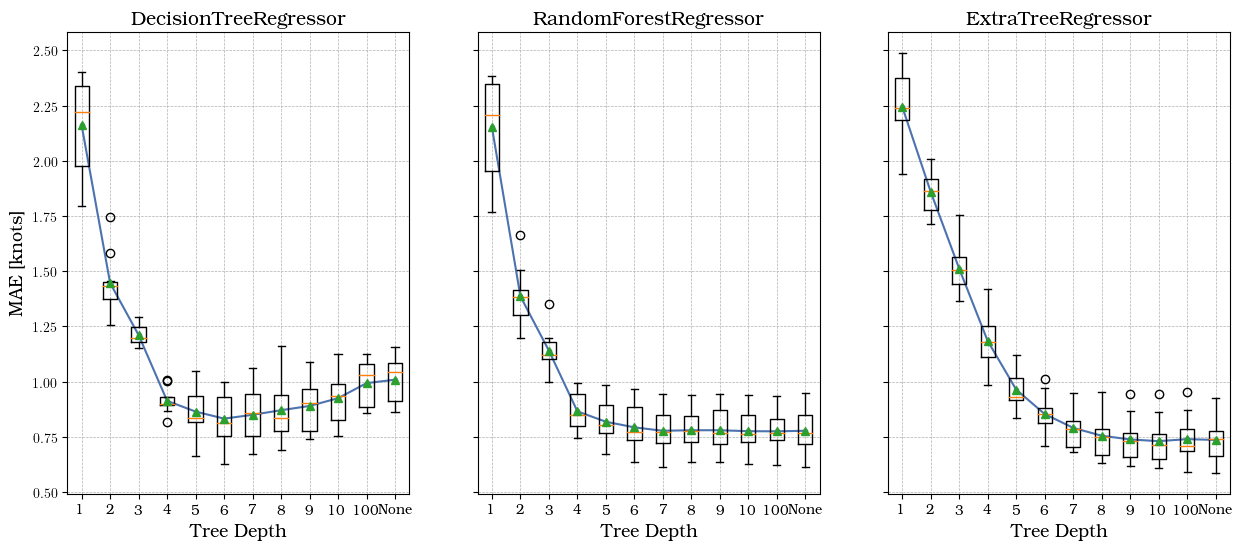

In [193]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 6), sharey=True)
plt.sca(axes[0])
depth_curve(x_test,y_test,regressor='dt',regname='DecisionTreeRegressor')
plt.sca(axes[1])
depth_curve(x_test,y_test,regressor='rf',regname='RandomForestRegressor')
plt.ylabel("")
plt.sca(axes[2])
depth_curve(x_test,y_test,regressor='et',regname='ExtraTreeRegressor')
plt.ylabel("")
plt.show()

``min_samples_split`` HPO

In [194]:
# explore tree based , tree depth. effect on performance
def split_curve(x,y,regressor,regname):
	from numpy import mean
	from numpy import std
	from sklearn.model_selection import cross_val_score
	from sklearn.model_selection import KFold

	# Parameter to plot in nice latex font

	plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})

	# get a list of models to evaluate
	def get_models_sp():
		models_sp = dict()
		# consider tree depths from 1 to 7 and None=full
		split = [2,3,4,5,6,7,8,9,10,20,30,40,50]
		for n in split:
			if regressor == 'dt':
				models_sp[str(n)] = DecisionTreeRegressor(min_samples_split=n)
			elif regressor == 'rf':
				models_sp[str(n)] = RandomForestRegressor(min_samples_split=n)
			elif regressor == 'et':
				models_sp[str(n)] = ExtraTreesRegressor(min_samples_split=n)	
		return models_sp

	# evaluate a given model using cross-validation
	def evaluate_model(model, x, y):
		# define the evaluation procedure
		cv = KFold(n_splits=10, shuffle=True, random_state=42)
		# evaluate the model and collect the results
		scores = cross_val_score(model, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
		# negative scores due to scoring mechanism of sklearn
		return -scores

	# get the models to evaluate
	models_sp = get_models_sp()
	# evaluate the models and store results
	results_sp, names_sp = list(), list()
	for name, model in models_sp.items():
		# evaluate the model
		scores_sp = evaluate_model(model, x, y)
		# store the results
		results_sp.append(scores_sp)
		names_sp.append(name)
		# summarize the performance along the way
		print('>%s %.3f (%.3f)' % (name, mean(scores_sp), std(scores_sp)))


	mean_sp = np.mean(results_sp,axis=1)
	min_error_sp = np.min(mean_sp)
	print(min_error_sp)
	bst_n_estimators_sp= np.argmin(mean_sp)
	print(f"The minimum MAE obtained is {min_error_sp:.3f}")
	plt.plot(names_sp,mean_sp,"b.-")
	plt.grid(linestyle = '--', linewidth = 0.5)
	plt.ylim(0,2.5)
	plt.xlabel(r"Minimum Sample to split ",fontsize=13)
	plt.ylabel(r"MAE [knots]",fontsize=13)
	plt.title(rf"{regname}", fontsize=14)
	plt.boxplot(results_sp, labels=names_sp,positions=range(len(names_sp)), showmeans=True)

>2 1.023 (0.094)
>3 1.006 (0.083)
>4 1.002 (0.064)
>5 0.991 (0.070)
>6 0.983 (0.058)
>7 0.974 (0.070)
>8 0.966 (0.071)
>9 0.937 (0.072)
>10 0.938 (0.099)
>20 0.941 (0.070)
>30 0.909 (0.079)
>40 0.904 (0.084)
>50 0.908 (0.082)
0.9035414983577137
The minimum MAE obtained is 0.904
>2 0.770 (0.045)
>3 0.773 (0.050)
>4 0.772 (0.048)
>5 0.778 (0.045)
>6 0.772 (0.049)
>7 0.768 (0.045)
>8 0.769 (0.047)
>9 0.777 (0.049)
>10 0.773 (0.048)
>20 0.799 (0.049)
>30 0.813 (0.053)
>40 0.816 (0.056)
>50 0.828 (0.067)
0.7681893526852592
The minimum MAE obtained is 0.768
>2 0.738 (0.060)
>3 0.732 (0.065)
>4 0.738 (0.068)
>5 0.738 (0.067)
>6 0.731 (0.065)
>7 0.732 (0.065)
>8 0.730 (0.062)
>9 0.733 (0.063)
>10 0.731 (0.068)
>20 0.747 (0.064)
>30 0.757 (0.069)
>40 0.775 (0.064)
>50 0.785 (0.074)
0.7302687634839262
The minimum MAE obtained is 0.730


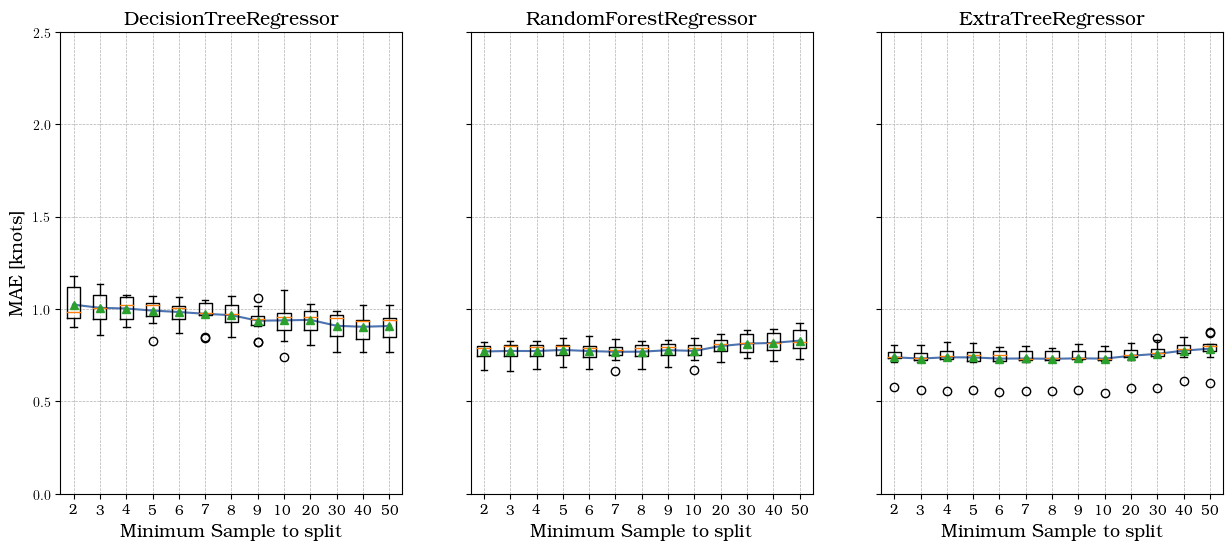

In [195]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 6), sharey=True)
plt.sca(axes[0])
split_curve(x_test,y_test,regressor='dt',regname='DecisionTreeRegressor')
plt.sca(axes[1])
split_curve(x_test,y_test,regressor='rf',regname='RandomForestRegressor')
plt.ylabel("")
plt.sca(axes[2])
split_curve(x_test,y_test,regressor='et',regname='ExtraTreeRegressor')
plt.ylabel("")
plt.show()

### HPO Optimisation
+ HPO optimisation using ``GridSearchCV`` for all tree based model
+ The process is computationally expensive
+ This section will be ignored by default


HPO for ``RandomForestRegressor()``

In [196]:
# Get the default parameter for RFR
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
pprint(model_rfr_ftr.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [197]:
# Modify the search space of RFR here

# Number of trees in random forest
n_estimators = [100,200,300,400,500,600,700,800,900,1000]
# Number of features to consider at every split
max_features = [int(x) for x in np.linspace(1, 23, num = 22)]

# max_features = [6,7,8,9,10,11,12]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3,4,5,6,7,8,9,10]
# Method of selecting samples for training each tree
# bootstrap = [True]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
pprint(random_grid)

{'max_depth': [10,
               20,
               30,
               40,
               50,
               60,
               70,
               80,
               90,
               100,
               110,
               120,
               130,
               140,
               150,
               160,
               170,
               180,
               190,
               200,
               None],
 'max_features': [1,
                  2,
                  3,
                  4,
                  5,
                  6,
                  7,
                  8,
                  9,
                  10,
                  11,
                  12,
                  13,
                  14,
                  15,
                  16,
                  17,
                  18,
                  19,
                  20,
                  21,
                  23],
 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 

In [198]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = model_rfr_ftr, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42,n_jobs=-1)# Fit the random search model
rf_random.fit(x_test, y_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110, 120,
                                                      130, 140, 150, 160, 170,
                                                      180, 190, 200, None],
                                        'max_features': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         15, 16, 17, 18, 19, 20,
                                                         21, 23],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, verbose=2)

In [199]:
# Optimal parameters
pprint(rf_random.best_params_)

{'max_depth': 10,
 'max_features': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 800}


HPO for ``DecisionTreeRegressor()``

In [200]:
# Get default parameter
pprint(model_dtr.get_params())

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}


In [201]:
# Search space for DTR

# Number of features to consider at every split
max_features = [int(x) for x in np.linspace(1, 23, num = 22)]
# Maximum number of levels in tree
max_depth = [1,2,3,4,5,6,7,8,9,10,100]
max_depth.append(None)
# max_depth = [None]
# Minimum number of samples required to split a node
min_samples_split = [2,3,4,5,6,7,8,9,10,15,20,30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,3,4,5,6,7,8,9,10]
random_grid_dtr = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,}
pprint(random_grid_dtr)

{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100, None],
 'max_features': [1,
                  2,
                  3,
                  4,
                  5,
                  6,
                  7,
                  8,
                  9,
                  10,
                  11,
                  12,
                  13,
                  14,
                  15,
                  16,
                  17,
                  18,
                  19,
                  20,
                  21,
                  23],
 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]}


In [202]:
dt_random = RandomizedSearchCV(estimator = model_dtr, param_distributions = random_grid_dtr, n_iter = 100, cv = 10, verbose=2, random_state=42,n_jobs=-1)# Fit the dt search model
dt_random.fit(x_test, y_test)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 100, None],
                                        'max_features': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         15, 16, 17, 18, 19, 20,
                                                         21, 23],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 15, 20,
                                                              30]},
                   random_state=42, verbose=2)

In [203]:
# Optimal parameters for DTR
pprint(dt_random.best_params_)

{'max_depth': 6,
 'max_features': 23,
 'min_samples_leaf': 6,
 'min_samples_split': 9}


HPO for ``ExtraTreeRegressor()``

In [204]:
# Get default parameter for ETR
from pprint import pprint
pprint(model_etr.get_params())

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [205]:
# Modify search space of ETR

# Number of trees in ETR
n_estimators = [100,200,300,400,500,600,700,800,900,1000]
# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = [int(x) for x in np.linspace(1, 23, num = 22)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [1,2,3,4,5,6,7,8,9,10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3,4,5,6,7,8,9,10]
# Method of selecting samples for training each tree
# bootstrap = [True]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
               #'bootstrap': bootstrap}
pprint(random_grid)

{'max_depth': [10,
               20,
               30,
               40,
               50,
               60,
               70,
               80,
               90,
               100,
               110,
               120,
               130,
               140,
               150,
               160,
               170,
               180,
               190,
               200,
               None],
 'max_features': [1,
                  2,
                  3,
                  4,
                  5,
                  6,
                  7,
                  8,
                  9,
                  10,
                  11,
                  12,
                  13,
                  14,
                  15,
                  16,
                  17,
                  18,
                  19,
                  20,
                  21,
                  23],
 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 '

In [206]:
 # search across 100 different combinations, and use all available cores
et_random = RandomizedSearchCV(estimator = model_etr, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=1,n_jobs=-1)# Fit the random search model
et_random.fit(x_test, y_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\Wafi\anaconda3\envs\geron1\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Wafi\anaconda3\envs\geron1\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Wafi\anaconda3\envs\geron1\lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "c:\Users\Wafi\anaconda3\envs\geron1\lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  Fi

RandomizedSearchCV(cv=5, estimator=ExtraTreesRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110, 120,
                                                      130, 140, 150, 160, 170,
                                                      180, 190, 200, None],
                                        'max_features': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         15, 16, 17, 18, 19, 20,
                                                         21, 23],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_samples_split': [1, 2, 3, 4, 5, 6,
                                                              7, 8, 9, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=1, verbose=2)

In [207]:
#Optimal parameters ETR
pprint(et_random.best_params_)

{'max_depth': 30,
 'max_features': 15,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 300}


### Evaluation of generated model

### Plot of trained tree
+ Requires that ``graphviz`` to be [installed](https://graphviz.org/download/) in local PC

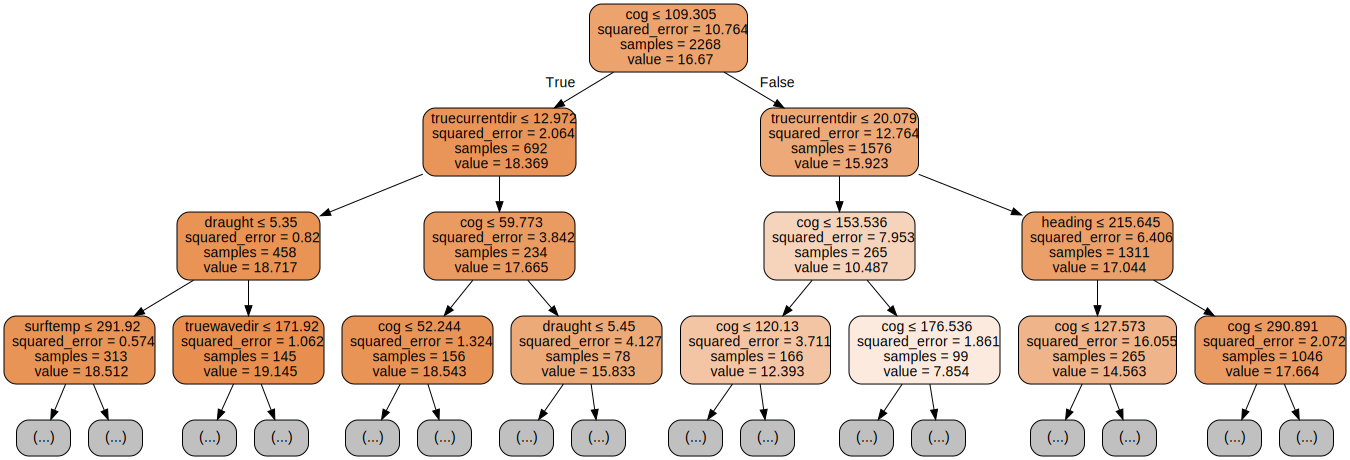

In [208]:
# Plot tree using graphviz, generate 1st tree in RFR (Graphviz must be installed in local computer)

from IPython.display import display
from sklearn import tree
import graphviz

dot_data_rfr = tree.export_graphviz(model_rfr_ftr_hpov.estimators_[1], 
                  feature_names=x_train.columns.values.tolist(),  
                #   class_names=class_names,  
                  filled=True, rounded=True,  
                  special_characters=True,
                   out_file=None,
                   max_depth=3,
                           )

display(graphviz.Source(dot_data_rfr))

# Only uncomment when about to generate PNG file, it will create source file that cannot be ignored by git

# graph = graphviz.Source(dot_data_rfr)
# graph.format = 'png'
# graph.render('rfr_mod_it1',view=True)

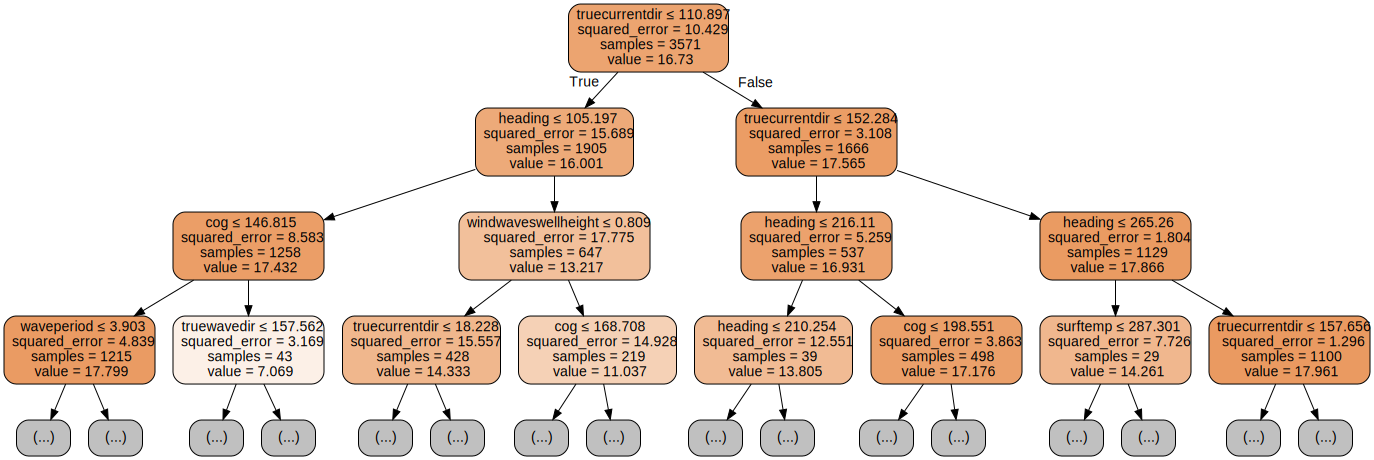

In [209]:
# Generate 1st tree in ETR

dot_data_etr = tree.export_graphviz(model_etr_hpov.estimators_[1], 
                  feature_names=x_train.columns.values.tolist(),  
                #   class_names=class_names,  
                  filled=True, rounded=True,  
                  special_characters=True,
                   out_file=None,
                   max_depth=3,
                           )

display(graphviz.Source(dot_data_etr))

# Only uncomment when about to generate PNG file, it will create source file that cannot be ignored by git

# graph = graphviz.Source(dot_data_etr)
# graph.format = 'png'
# graph.render('etr_mod_it1',view=True)

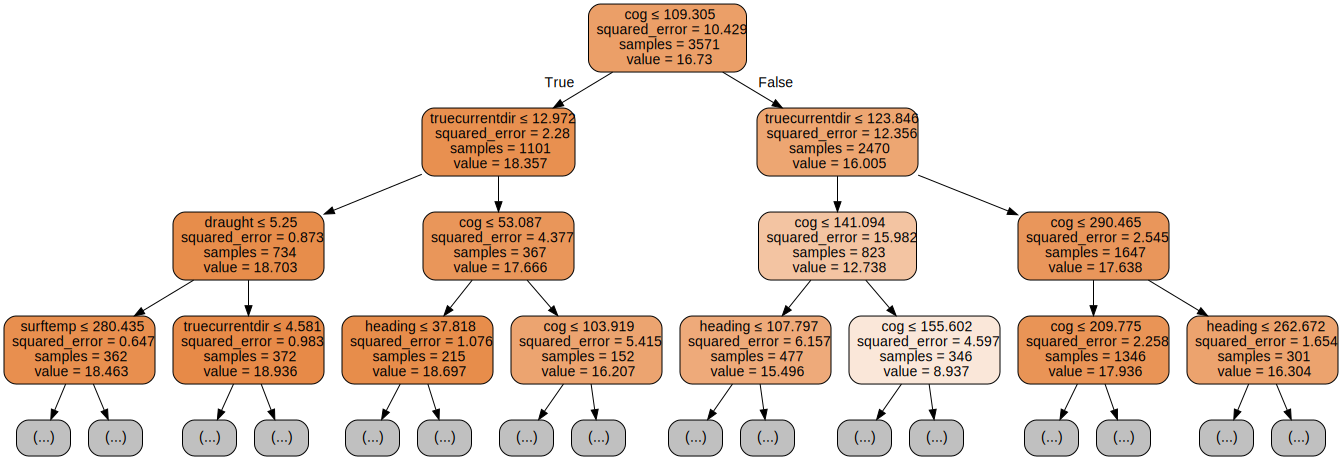

In [210]:
# Generate 1st tree in DTR

dot_data_dtr = tree.export_graphviz(model_dtr_hpov, 
                  feature_names=x_train.columns.values.tolist(),  
                #   class_names=class_names,  
                  filled=True, rounded=True,  
                  special_characters=True,
                   out_file=None,
                   max_depth=3,
                           )

display(graphviz.Source(dot_data_dtr))

# Only uncomment when about to generate PNG file, it will create source file that cannot be ignored by git

# graph = graphviz.Source(dot_data_dtr)
# graph.format = 'png'
# graph.render('dtr_mod_1tree',view=True)

### Feature importance 
+ Informally defined as how frequent the feature is used to split a node, [Sklearn](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)
+ Provide a good overview and it is an implicit feature selection post training

In [211]:
def model_importance(model_type):
    mod_imp = model_type.feature_importances_
    df_mod_imp = pd.DataFrame(mod_imp,index= x_train.columns,columns=["Importance"])
    print(df_mod_imp.sort_values(by=['Importance'],ascending=False))


In [212]:
# Plot feature importance of all features
def plot_feature_importance(model_type,names,model_name):

    importance = model_type.feature_importances_

    # #Create arrays from feature importance and feature names
    # feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Sort feature importances in ascending order
    sorted_indices = np.argsort(importance)
    sorted_feature_importances = importance[sorted_indices]
    sorted_feature_names = np.array(names)[sorted_indices]  # Replace with your actual feature names

    # Create a bar plot for sorted feature importances
    plt.figure(figsize=(10,6))
    plt.barh(range(len(sorted_feature_names)), sorted_feature_importances, color='black')
    plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
    plt.xlabel('Importance Value')
    plt.ylabel('Feature Name')
    plt.title(f'Feature Importances of {model_name}')
    plt.xlim(0,0.7)
    plt.grid(linestyle = '--', linewidth = 0.4,axis='x')
    plt.tight_layout()

    # Show importance values on the plot
    for i, v in enumerate(sorted_feature_importances):
        plt.text(v + 0.001, i, str(round(v, 4)), color='black', fontweight='bold')


In [213]:
# Plot feature importance without COG and heading 
def plot_feature_importance_norank(model_type,names,model_name):

    importance = model_type.feature_importances_

    # #Create arrays from feature importance and feature names
    # feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Sort feature importances in ascending order
    sorted_indices = np.argsort(importance)
    # Exclude the first and second-ranked features
    exclude_indices = [sorted_indices[10], sorted_indices[11]]
    remaining_indices = [i for i in sorted_indices if i not in exclude_indices]
    remaining_feature_importances = importance[remaining_indices]
    remaining_feature_names = [feature_names[i] for i in remaining_indices]

    # Sort the remaining feature importances in ascending order
    sorted_remaining_indices = np.argsort(remaining_feature_importances)
    sorted_feature_importances = remaining_feature_importances[sorted_remaining_indices]
    sorted_feature_names = [remaining_feature_names[i] for i in sorted_remaining_indices]


    # Create a bar plot for sorted feature importances
    plt.figure(figsize=(10,6))
    plt.barh(range(len(sorted_feature_names)), sorted_feature_importances, color='black')
    plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
    plt.xlabel('Importance Value')
    plt.ylabel('Feature Name')
    plt.title(f'Feature Importances of {model_name}')
    plt.xlim(0,0.025)
    plt.grid(linestyle = '--', linewidth = 0.4,axis='x')
    plt.tight_layout()

    # Show importance values on the plot
    for i, v in enumerate(sorted_feature_importances):
        plt.text(v + 0.001, i, str(round(v, 4)), color='black', fontweight='bold')


                     Importance
cog                    0.444119
truecurrentdir         0.309752
heading                0.193231
waveperiod             0.010566
windwaveswellheight    0.009365
draught                0.008652
truewinddir            0.004626
oceantemperature       0.004567
surftemp               0.004032
curspeed               0.003915
windspeed              0.003757
truewavedir            0.003418


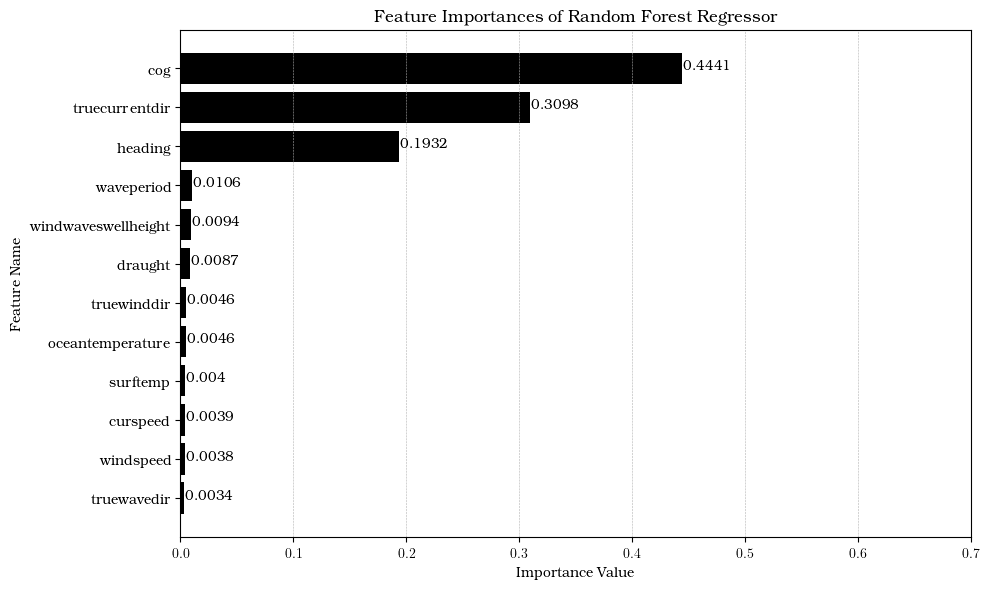

In [214]:
model_importance(model_rfr_ftr_hpov)
plot_feature_importance(model_rfr_ftr_hpov,x_train.columns,'Random Forest Regressor')
plt.show()


In [215]:
# plot_feature_importance_norank(model_rfr_ftr_hpov,x_train.columns,'Random Forest Regressor')
# plt.show()

                     Importance
cog                    0.531356
truecurrentdir         0.221368
heading                0.182856
draught                0.013021
windwaveswellheight    0.011902
waveperiod             0.011782
curspeed               0.004775
truewavedir            0.004725
truewinddir            0.004655
surftemp               0.004649
oceantemperature       0.004571
windspeed              0.004341


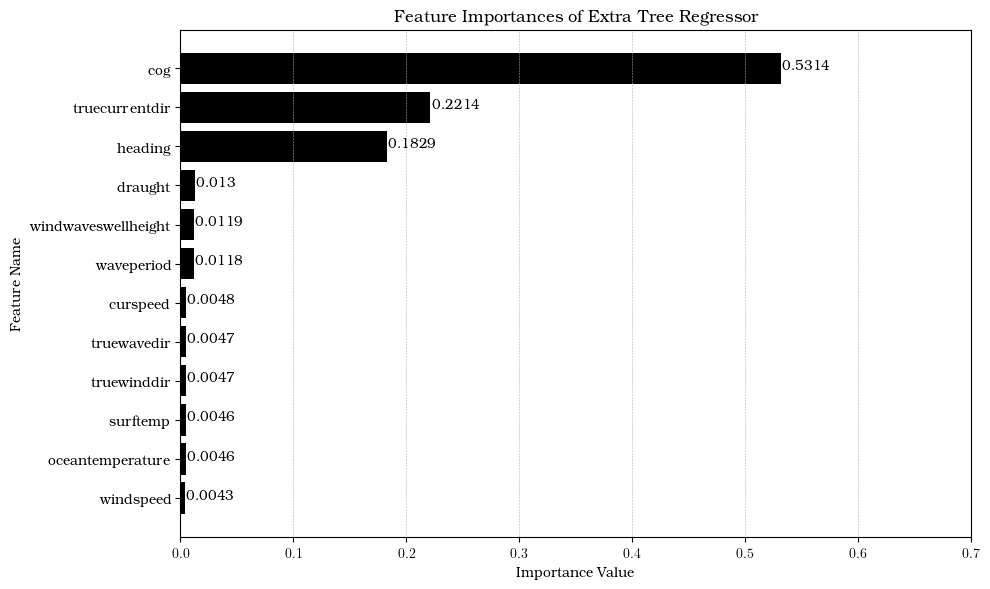

In [216]:
model_importance(model_etr_hpov)
plot_feature_importance(model_etr_hpov,x_train.columns,'Extra Tree Regressor')
plt.show()

In [217]:
# plot_feature_importance_norank(model_etr_hpov,x_train.columns,'Extra Tree Regressor')
# plt.show()

                     Importance
cog                    0.497703
truecurrentdir         0.416777
heading                0.077238
draught                0.002514
windwaveswellheight    0.001704
windspeed              0.001485
waveperiod             0.001257
surftemp               0.000597
truewavedir            0.000536
oceantemperature       0.000114
truewinddir            0.000074
curspeed               0.000000


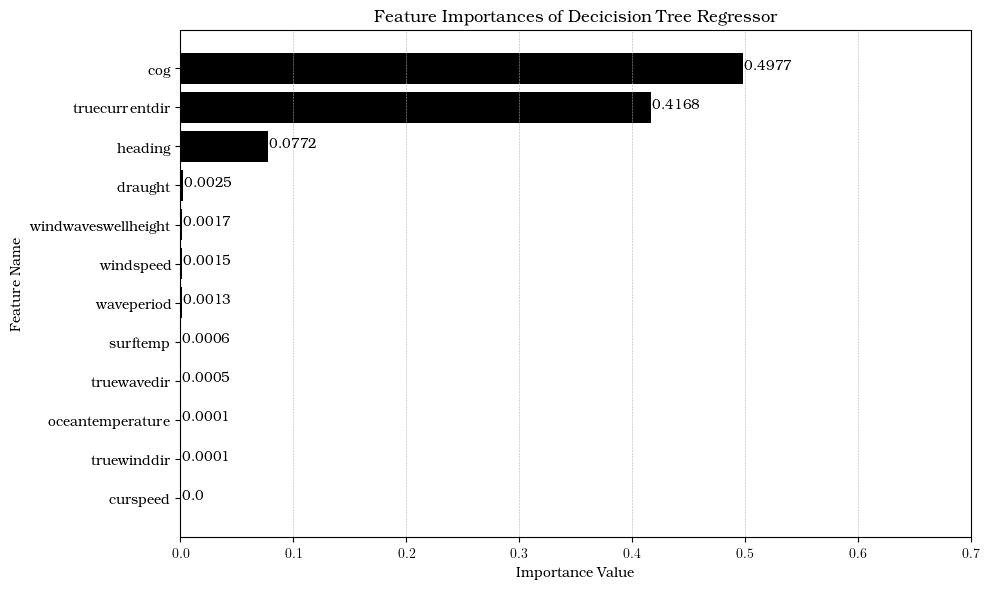

In [218]:
model_importance(model_dtr_hpov)
plot_feature_importance(model_dtr_hpov,x_train.columns,'Decicision Tree Regressor')
plt.show()

In [219]:
# plot_feature_importance_norank(model_dtr_hpov,x_train.columns,'Decicision Tree Regressor')
# plt.show()

### Cross validation evaluation of trained model
+ The model is subjected to 10-fold cross validation
+ The following metrics are used to evaluate the models
    + R<sup>2</sup>
    + explained Variance
    + MAE
    + RMSE
    + MAD

In [220]:
def evaluate(model, features_x, labels_y):
    from sklearn.model_selection import cross_val_score

    score_r2 = cross_val_score(model,features_x,labels_y,
                           scoring='r2',cv=10)
    rsquared = score_r2.mean()
    stadev_rsquared = score_r2.std()
    max_rsquared = score_r2.max()
    min_rsquared = score_r2.min()

    score_expVar = cross_val_score(model,features_x,labels_y,
                           scoring='explained_variance',cv=10)
    expVar = score_expVar.mean()
    stadev_expVar = score_expVar.std()
    max_expVar = score_expVar.max()
    min_expVar = score_expVar.min()

    score_MAE = cross_val_score(model,features_x,labels_y,
                           scoring='neg_mean_absolute_error',cv=10)
    MAE = -score_MAE.mean()
    stadev_MAE = score_MAE.std()
    max_MAE = -score_MAE.max()
    min_MAE = -score_MAE.min()

    score_MAD = cross_val_score(model,features_x,labels_y,
                           scoring='neg_median_absolute_error',cv=10)
    MAD = -score_MAD.mean()
    stadev_MAD = score_MAD.std()
    max_MAD = -score_MAD.max()
    min_MAD = -score_MAD.min()



    score_MSE = cross_val_score(model,features_x,labels_y,
                           scoring='neg_root_mean_squared_error',cv=10)
    score_RMSE = np.sqrt(-score_MSE)
    RMSE = score_RMSE.mean()
    stadev_RMSE = score_RMSE.std()
    max_RMSE = score_RMSE.max()
    min_RMSE = score_RMSE.min()


    print(f"Model Performance of {model}")
    print(f"R^2 = {rsquared:0.4f}, std = {stadev_rsquared:0.4f}, max = {max_rsquared:0.4f}, min = {min_rsquared:0.4f}")
    print(f"explained Variance = {expVar:0.4f}, std = {stadev_expVar:0.4f}, max = {max_expVar:0.4f}, min = {min_expVar:0.4f}")
    print(f"MAE = {MAE:0.4f}, std = {stadev_MAE:0.4f}, max = {max_MAE:0.4f}, min = {min_MAE:0.4f}")
    print(f"RMSE = {RMSE:0.4f}, std = {stadev_RMSE:0.4f}, max = {max_RMSE:0.4f}, min = {min_RMSE:0.4f}")
    print(f"MAD = {MAD:0.4f}, std = {stadev_MAD:0.4f}, max = {max_MAD:0.4f}, min = {min_MAD:0.4f}\n")

    return score_r2,score_expVar,score_MAE,score_RMSE,score_MAD        

Evaluation of RFR

In [221]:
r2_rf,expVar_rf,MAE_rf,RMSE_rf,MAD_rf = evaluate(model_rfr_ftr,x_train,y_train)

Model Performance of RandomForestRegressor(random_state=42)
R^2 = 0.8851, std = 0.0257, max = 0.9238, min = 0.8321
explained Variance = 0.8854, std = 0.0254, max = 0.9243, min = 0.8333
MAE = 0.7015, std = 0.0472, max = 0.6425, min = 0.7828
RMSE = 1.0410, std = 0.0658, max = 1.1858, min = 0.9637
MAD = 0.4781, std = 0.0441, max = 0.4208, min = 0.5514



In [222]:
# Optimised model performance

r2_rfo,expVar_rfo,MAE_rfo,RMSE_rfo,MAD_rfo = evaluate(model_rfr_ftr_hpov,x_train,y_train)

Model Performance of RandomForestRegressor(max_depth=10, max_features=10, min_samples_leaf=2,
                      min_samples_split=5, n_estimators=800, random_state=42)
R^2 = 0.8854, std = 0.0247, max = 0.9197, min = 0.8360
explained Variance = 0.8856, std = 0.0245, max = 0.9201, min = 0.8368
MAE = 0.7051, std = 0.0471, max = 0.6446, min = 0.7956
RMSE = 1.0407, std = 0.0636, max = 1.1788, min = 0.9656
MAD = 0.4932, std = 0.0366, max = 0.4424, min = 0.5693



Evaluation of ETR

In [223]:
r2_et,expVar_et,MAE_et,RMSE_et,MAD_et = evaluate(model_etr,x_train,y_train)

Model Performance of ExtraTreesRegressor(random_state=42)
R^2 = 0.9043, std = 0.0157, max = 0.9290, min = 0.8777
explained Variance = 0.9045, std = 0.0155, max = 0.9291, min = 0.8789
MAE = 0.6607, std = 0.0402, max = 0.6001, min = 0.7376
RMSE = 0.9968, std = 0.0522, max = 1.0955, min = 0.8964
MAD = 0.4641, std = 0.0348, max = 0.4229, min = 0.5447



In [224]:
# Optimised model performance 

r2_eto,expVar_eto,MAE_eto,RMSE_eto,MAD_eto = evaluate(model_etr_hpov,x_train,y_train)

Model Performance of ExtraTreesRegressor(max_depth=30, max_features=16, min_samples_split=8,
                    n_estimators=300, random_state=42)
R^2 = 0.9046, std = 0.0153, max = 0.9285, min = 0.8812
explained Variance = 0.9049, std = 0.0152, max = 0.9286, min = 0.8823
MAE = 0.6622, std = 0.0422, max = 0.5938, min = 0.7374
RMSE = 0.9958, std = 0.0503, max = 1.0876, min = 0.8979
MAD = 0.4560, std = 0.0350, max = 0.4160, min = 0.5298



Evaluation of DTR

In [225]:
r2_dt,expVar_dt,MAE_dt,RMSE_dt,MAD_dt = evaluate(model_dtr,x_train,y_train)

Model Performance of DecisionTreeRegressor()
R^2 = 0.7887, std = 0.0381, max = 0.8626, min = 0.7363
explained Variance = 0.7901, std = 0.0462, max = 0.8641, min = 0.7195
MAE = 0.9437, std = 0.0640, max = 0.8524, min = 1.0455
RMSE = 1.2115, std = 0.0607, max = 1.3122, min = 1.1232
MAD = 0.5950, std = 0.0356, max = 0.5410, min = 0.6585



In [226]:
# Optimised model performance

r2_dto,expVar_dto,MAE_dto,RMSE_dto,MAD_dto = evaluate(model_dtr_hpov,x_train,y_train)

Model Performance of DecisionTreeRegressor(max_depth=6, max_features=11, min_samples_leaf=9,
                      min_samples_split=8)
R^2 = 0.8366, std = 0.0294, max = 0.8909, min = 0.7863
explained Variance = 0.8254, std = 0.0343, max = 0.8871, min = 0.7810
MAE = 0.8450, std = 0.0496, max = 0.7530, min = 0.9289
RMSE = 1.1447, std = 0.0495, max = 1.2454, min = 1.0610
MAD = 0.5873, std = 0.0454, max = 0.4674, min = 0.6482



Evaluation of MLR 

In [227]:
r2_mlr,expVar_mlr,MAE_mlr,RMSE_mlr,MAD_mlr = evaluate(model_mlr,x_train,y_train)

Model Performance of LinearRegression()
R^2 = 0.6924, std = 0.0763, max = 0.8351, min = 0.5881
explained Variance = 0.6931, std = 0.0766, max = 0.8379, min = 0.5881
MAE = 1.1110, std = 0.0878, max = 0.9599, min = 1.2443
RMSE = 1.3283, std = 0.0858, max = 1.4316, min = 1.1689
MAD = 0.8546, std = 0.0513, max = 0.7563, min = 0.9249



In [228]:
def evaluate_SOG(model,x_date,y_date):
    from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,explained_variance_score,median_absolute_error,mean_absolute_error
    
    def label_predict(model,test_features):
        predictions = model.predict(test_features)
        return predictions
    
    predictions = label_predict(model,x_date)

    Rsquared_SOG = r2_score(y_date,predictions)
    expVar_SOG = explained_variance_score(y_date,predictions)
    MAE_SOG = mean_absolute_error(y_date,predictions)
    RMSE_SOG = np.sqrt(mean_squared_error(y_date, predictions))
    MAD_SOG = median_absolute_error(y_date,predictions)
    MAPE_SOG = mean_absolute_percentage_error(y_date, predictions)
    

    print(f"Model Performance of {model}")
    print(f"R^2 SOG = {Rsquared_SOG:0.4f}")
    print(f"Explained Variance SOG = {expVar_SOG:0.4f}")
    print(f"MAE SOG = {MAE_SOG:0.4f} Knots")    
    print(f"RMSE SOG = {RMSE_SOG:0.4f} Knots")
    print(f"MAD SOG = {MAD_SOG:0.4f} Knots")    
    print(f"MAPE SOG = {MAPE_SOG*100:0.4f} %")

In [229]:
evaluate_SOG(model_rfr_ftr_hpov,x_test,y_test)

Model Performance of RandomForestRegressor(max_depth=10, max_features=10, min_samples_leaf=2,
                      min_samples_split=5, n_estimators=800, random_state=42)
R^2 SOG = 0.8924
Explained Variance SOG = 0.8925
MAE SOG = 0.7046 Knots
RMSE SOG = 1.0614 Knots
MAD SOG = 0.4964 Knots
MAPE SOG = 4.6932 %


In [230]:
evaluate_SOG(model_etr_hpov,x_test,y_test)

Model Performance of ExtraTreesRegressor(max_depth=30, max_features=16, min_samples_split=8,
                    n_estimators=300, random_state=42)
R^2 SOG = 0.9045
Explained Variance SOG = 0.9046
MAE SOG = 0.6664 Knots
RMSE SOG = 0.9998 Knots
MAD SOG = 0.4662 Knots
MAPE SOG = 4.4579 %


### Learning Curves
+ Helps to identify the benefits of performing HPO
+ At certain point, not tangible performance gain can be obtained

In [231]:
# Parameter to reset plot properties to default and change the font to tex

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})

In [232]:
# Functions for MAE and Rsquared plots for learning curve

from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit ,learning_curve

def learn_plotrmse(model,x_data,y_data,model_name):
    train_sizes, train_scores, test_scores = learning_curve(estimator = model, X=x_data, y=y_data,
                                                        cv=10, train_sizes=np.linspace(0.1, 1.0, 20),
                                                        n_jobs=-1,scoring="neg_mean_absolute_error")
	# Parameter to plot in nice latex fonts
    plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
    #
    # Calculate training and test mean and std
    #
    train_scores = np.sqrt(-train_scores)
    test_scores = np.sqrt(-test_scores)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    #
    # Plot the learning curve
    #
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label=r'Training Error')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', marker='d', markersize=5, linestyle='--', label=r'Validation Error')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.title(fr'Learning Curve of {model_name}')
    plt.xlabel(r'Training Data Size')
    plt.ylabel(r'MAE [knots]')
    # plt.xlim(200,2700)
    plt.ylim(0,2)
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.legend(loc='lower right')
    # plt.show()
    
def learn_plotr2(model,x_data,y_data,model_name):
    train_sizes, train_scores, test_scores = learning_curve(estimator = model, X=x_data, y=y_data,
                                                        cv=10, train_sizes=np.linspace(0.1, 1.0,20),
                                                        n_jobs=-1,scoring="r2")
	# Parameter to plot in nice latex fonts
    plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
    #
    # Calculate training and test mean and std
    #
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    #
    # Plot the learning curve
    #
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label=r'Training Score')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', marker='d', markersize=5, linestyle='--', label=r'Validation Score')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.title(fr'Learning Curve of {model_name}')
    plt.xlabel(r'Training Data Size')
    plt.ylabel(r'Rsquared')
    plt.ylim(0.5,1)
    # plt.xlim(200,2700)
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.legend(loc='lower right')
    # plt.show()


Understanding Effect of Hyperparameter optimisation

Learning Curve DTR

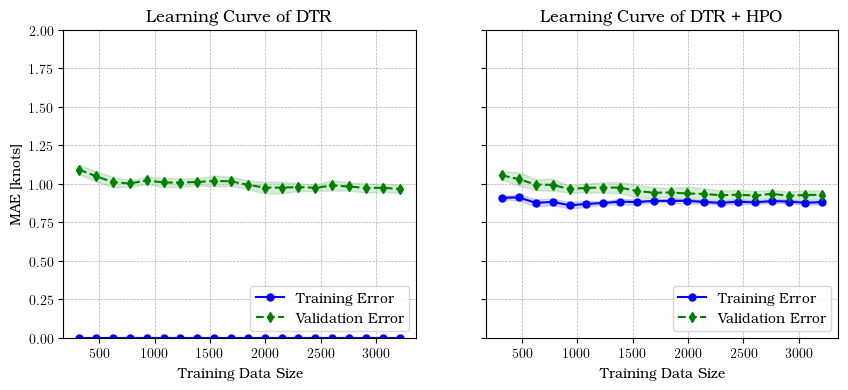

In [233]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
learn_plotrmse(model_dtr,x_train,y_train,'DTR')
plt.sca(axes[1])
learn_plotrmse(model_dtr_hpov,x_train,y_train,'DTR + HPO')
plt.ylabel("")
plt.show()

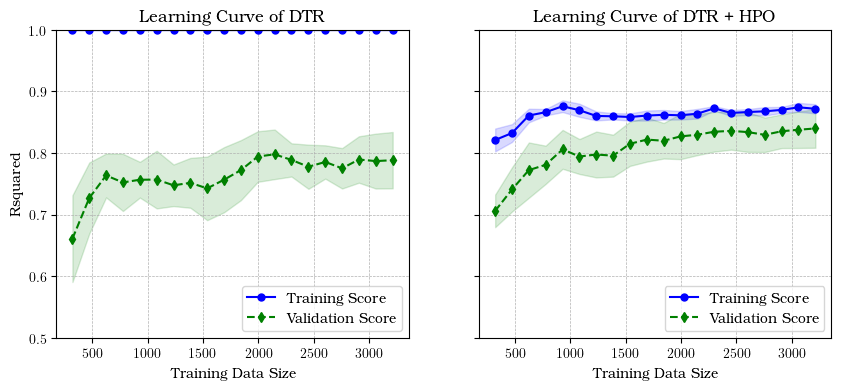

In [234]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
learn_plotr2(model_dtr,x_train,y_train,'DTR')
plt.sca(axes[1])
learn_plotr2(model_dtr_hpov,x_train,y_train,'DTR + HPO')
plt.ylabel("")
plt.show()

Learning Curve RFR

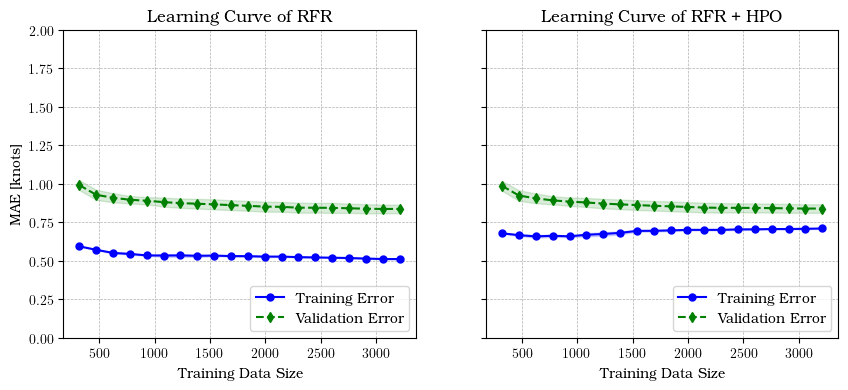

In [235]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
learn_plotrmse(model_rfr_ftr,x_train,y_train,'RFR')
plt.sca(axes[1])
learn_plotrmse(model_rfr_ftr_hpov,x_train,y_train,'RFR + HPO')
plt.ylabel("")
plt.show()

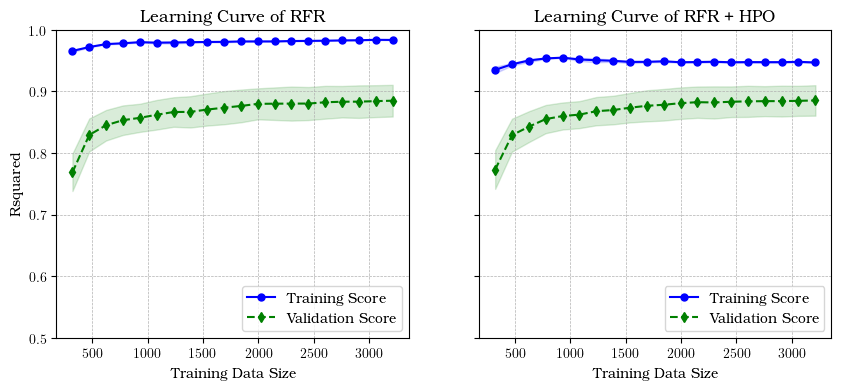

In [236]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
learn_plotr2(model_rfr_ftr,x_train,y_train,'RFR')
plt.sca(axes[1])
learn_plotr2(model_rfr_ftr_hpov,x_train,y_train,'RFR + HPO')
plt.ylabel("")
plt.show()

Learning Curve ETR

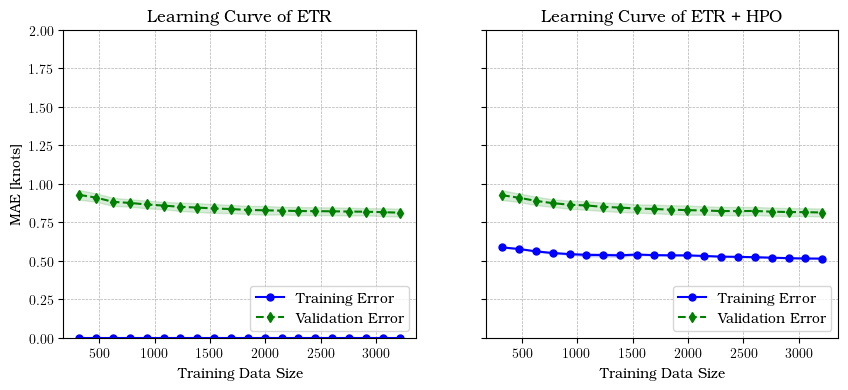

In [237]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
learn_plotrmse(model_etr,x_train,y_train,'ETR')
plt.sca(axes[1])
learn_plotrmse(model_etr_hpov,x_train,y_train,'ETR + HPO')
plt.ylabel("")
plt.show()

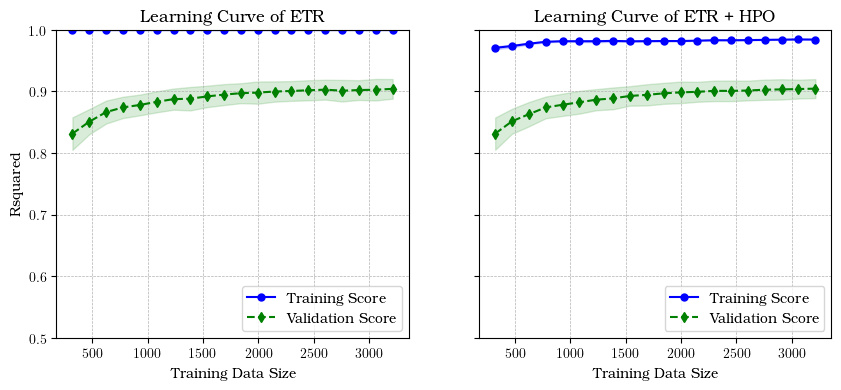

In [238]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
learn_plotr2(model_etr,x_train,y_train,'ETR')
plt.sca(axes[1])
learn_plotr2(model_etr_hpov,x_train,y_train,'ETR + HPO')
plt.ylabel("")
plt.show()

### Boxplots of the k-Fold evaluations

<Figure size 500x300 with 0 Axes>

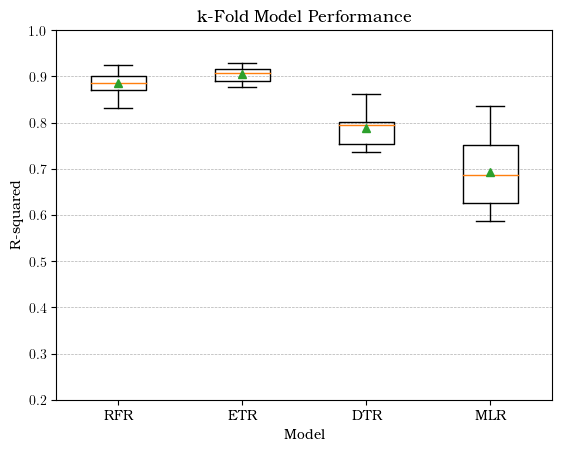

In [239]:
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
scores = [r2_rf,r2_et,r2_dt,r2_mlr]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title("k-Fold Model Performance")
plt.ylabel("R-squared")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(0.2,1.0)
plt.boxplot(scores,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['RFR', 'ETR',
                    'DTR', 'MLR'])
plt.show()

<Figure size 500x300 with 0 Axes>

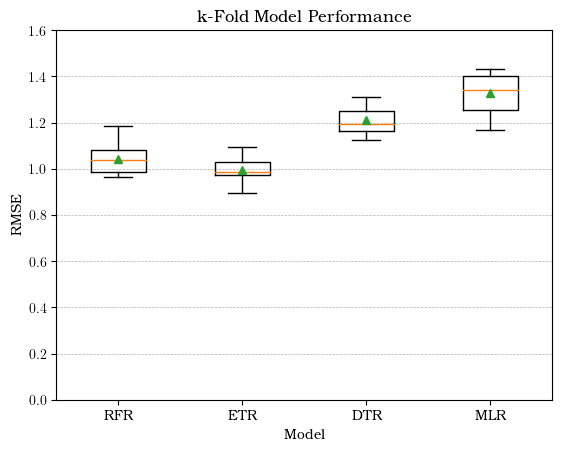

In [240]:
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
scores_rmse = [np.abs(RMSE_rf),np.abs(RMSE_et),np.abs(RMSE_dt),np.abs(RMSE_mlr)]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
fig,ax = plt.subplots() 
plt.title("k-Fold Model Performance")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.ylim(0,1.6)
plt.yscale('linear')
ax.boxplot(scores_rmse,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['RFR', 'ETR',
                    'DTR', 'MLR'])
plt.show()

Comparison for optimised model

In [241]:
def r2_plot_opt(r2_mod1,r2_mod1opt,r2_mod2,r2_mod2opt,r2_mod3,r2_mod3opt):
    scores_opt = [r2_mod1,r2_mod1opt,r2_mod2,r2_mod2opt,r2_mod3,r2_mod3opt]
    # fig = plt.figure(figsize=(5,3))
    # Creating axes instance
    fig,ax = plt.subplots() 
    plt.title("k-Fold Model Performance")
    plt.ylabel("R-squared")
    plt.xlabel("Model")
    plt.ylim(0.2,1.0)
    plt.yscale('linear')
    ax.boxplot(scores_opt,showmeans=True)
    plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
    ax.set_xticklabels([r'RFR', r'$RFR_{opt}$',
                        r'ETR', r'$ETR_{opt}$',
                        r'DTR',r'$DTR_{opt}$'])

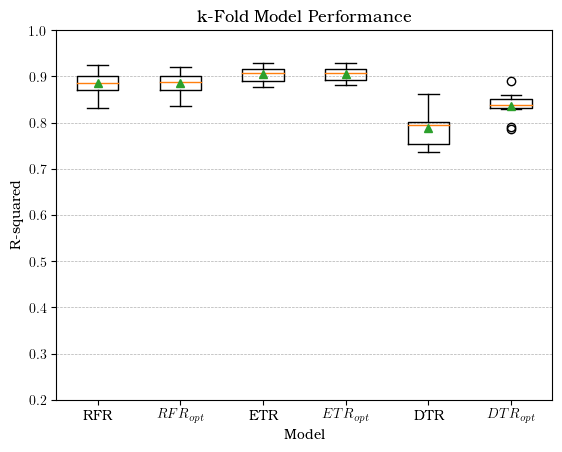

In [242]:
r2_plot_opt(r2_rf,r2_rfo,r2_et,r2_eto,r2_dt,r2_dto)
plt.show()

In [243]:
def rmse_plot_opt(rmse_mod1,rmse_mod1opt,rmse_mod2,rmse_mod2opt,rmse_mod3,rmse_mod3opt):
    rmse_opt = [rmse_mod1,rmse_mod1opt,rmse_mod2,rmse_mod2opt,rmse_mod3,rmse_mod3opt]
    # fig = plt.figure(figsize=(5,3))
    # Creating axes instance
    fig,ax = plt.subplots() 
    plt.title("k-Fold Model Performance")
    plt.ylabel("RMSE [knots]")
    plt.xlabel("Model")
    plt.yscale('linear')
    plt.ylim(0,1.4)
    ax.boxplot(rmse_opt,showmeans=True)
    plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
    ax.set_xticklabels([r'RFR', r'$RFR_{opt}$',
                        r'ETR', r'$ETR_{opt}$',
                        r'DTR',r'$DTR_{opt}$'])

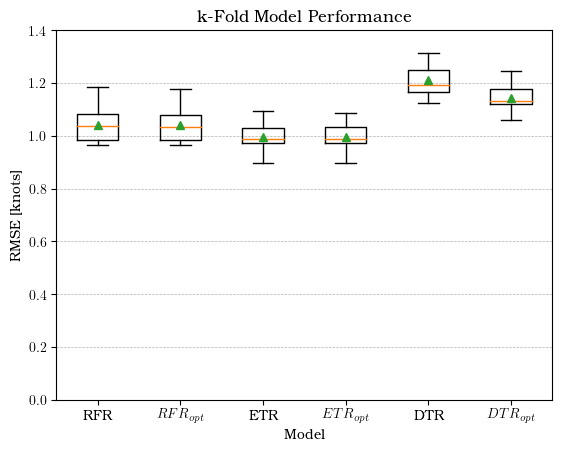

In [244]:
rmse_plot_opt(RMSE_rf,RMSE_rfo,RMSE_et,RMSE_eto,RMSE_dt,RMSE_dto)
plt.show()


In [245]:
def mae_plot_opt(mae_mod1,mae_mod1opt,mae_mod2,mae_mod2opt,mae_mod3,mae_mod3opt):
    mae_opt = [mae_mod1,mae_mod1opt,mae_mod2,mae_mod2opt,mae_mod3,mae_mod3opt]
    fig = plt.figure(figsize=(5,3))
    # Creating axes instance
    fig,ax = plt.subplots() 
    plt.title("k-Fold Model Performance")
    plt.ylabel("MAE [knots]")
    plt.xlabel("Model")
    plt.yscale('linear')
    plt.ylim(0,1.4)
    ax.boxplot(mae_opt,showmeans=True)
    plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
    ax.set_xticklabels([r'RFR', r'$RFR_{opt}$',
                        r'ETR', r'$ETR_{opt}$',
                        r'DTR',r'$DTR_{opt}$'])

<Figure size 500x300 with 0 Axes>

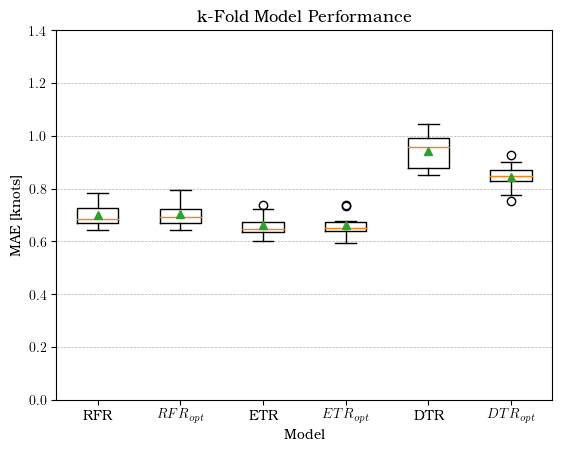

In [246]:
mae_plot_opt(-MAE_rf,-MAE_rfo,-MAE_et,-MAE_eto,-MAE_dt,-MAE_dto)
plt.show()

In [247]:
def mad_plot_opt(mad_mod1,mad_mod1opt,mad_mod2,mad_mod2opt,mad_mod3,mad_mod3opt):
    mad_opt = [mad_mod1,mad_mod1opt,mad_mod2,mad_mod2opt,mad_mod3,mad_mod3opt]
    fig = plt.figure(figsize=(5,3))
    # Creating axes instance
    fig,ax = plt.subplots() 
    plt.title("k-Fold Model Performance")
    plt.ylabel("MAD [knots]")
    plt.xlabel("Model")
    plt.yscale('linear')
    plt.ylim(0,1.4)
    ax.boxplot(mad_opt,showmeans=True)
    plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
    ax.set_xticklabels([r'RFR', r'$RFR_{opt}$',
                        r'ETR', r'$ETR_{opt}$',
                        r'DTR',r'$DTR_{opt}$'])

<Figure size 500x300 with 0 Axes>

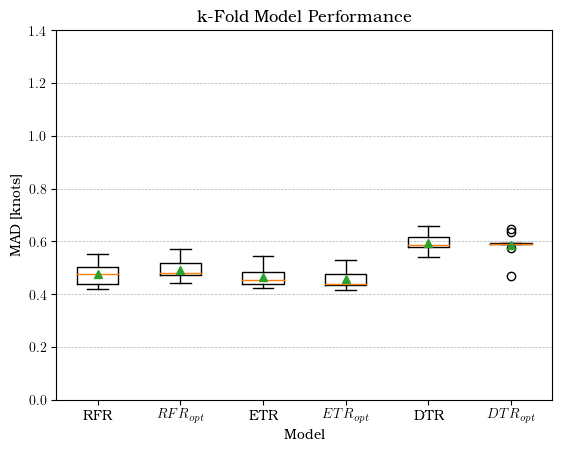

In [248]:
mad_plot_opt(-MAD_rf,-MAD_rfo,-MAD_et,-MAD_eto,-MAD_dt,-MAD_dto)
plt.show()